<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    gbvs Mini-Challenge 1 <br> 
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Si Ben Tran im HS 2023.<br>Bachelor of Science FHNW in Data Science.
</p>

In dieser Mini-Challenge werden LE1 und LE2 von gbsv geprüft. Jede:r Studierende:r hat eine individualisierte Aufgabenstellung. Die Abgabe soll ebenfalls einzigartig sein. Dazu wird in dieser Mini-Challenge ein Steckbrief über ein Land in Form von Experimenten in Bild- und Signalverarbeitung zusammengestellt. Das heisst, du wählst passend zu deinem gewählten Land (siehe Google Docs) und den dir zugeordneten Aufgaben Bilder und Signale aus. Wenn du z.B. die Schweiz hast, könntest du Löcher in Bildern vom Emmentalerkäse finden. Die Programmiersprache und die Code-Dokumentation darf frei gewählt werden. Sofern nicht anders erwähnt, dürfen vorhandene Bibliotheken verwendet werden. Gebe die Quellen deiner Daten und ggf. deines Codes an. 

Teil der Mini-Challenge ist es, die Abgabe von jemand anderem zu bewerten. 

Abgaben (Termin siehe Spaces): Code, Resultate und Report gemäss Vorlage. Fürs Peer-Grading sollen die Abgaben anonymisiert sein. 
Google Docs: Ländereinschreibung


# 1 Grundlagen Bild- und Signalverarbeitung (LE1) 

## 1.1 Bildeigenschaften
Suche verschiedene Bilder unterschiedlicher Szenen passend zu deinem Land oder nehme selbst welche auf. Die Bilder sollen sich eignen, um Anpassungen der Bildeigenschaften {'Wertebereiche von Pixeln, Schärfe, Farbräume (Korrektur oder Transformationen)'} in Experimenten zu demonstrieren. Messe dazu zuerst auf deinen Bildern die dir zugeordneten Bildeigenschaften mittels geeigneten Metriken. Definiere danach ein Ziel, wie die dir zugeordneten Bildeigenschaften verändert werden sollen. Definiere ein paar Experimente, um dieses Ziel zu erreichen, und führe die Experimente mit deinen Bildern und geeigneten Methoden aus. Analysiere die Histogramme der ursprünglichen Bilder und während deinen Experimenten. Führe ggf. eine Histogramm-Entzerrung (Englisch: histogram equalization) durch. Diskutiere deine Daten-, Parameter- und Methodenwahl und die erzielten Ergebnisse. 

In [ ]:
# Data Science standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Operating System
import os

# Image libraries
from PIL import Image
from skimage import color, exposure
from skimage.metrics import peak_signal_noise_ratio

# Signal libraries
from IPython.display import Audio
import librosa
import soundfile as sf
import pywt
import cv2 


### 1.1.1 Bilder Laden 

Zuerst haben wir 20 Bilder aus dem Internet heruntergeladen, und die verbleibenden fünf wurden von Dall-E generiert. Insgesamt befinden sich nun 26 Dateien in unserem Bilderpool, die numerisch geordnet sind. Beachten jedoch, dass das letzte Bild mit der Nummer 26 erst gegen Ende der Mini-Challenge aus dem Internet bezogen wurde.

Um unsere Visualisierung vorzunehmen, beginnen wir mit den ersten 25 Bildern und wählen dann jeweils zwei passende Bilder für jedes der drei geplanten Experimente aus. Das ergibt insgesamt sechs Bilder, die für die Experimente zu den Themen `Wertebereich von Pixel`, `Schärfe` und `Farbräume (Korrektur oder Transformationen)` verwendet werden. 

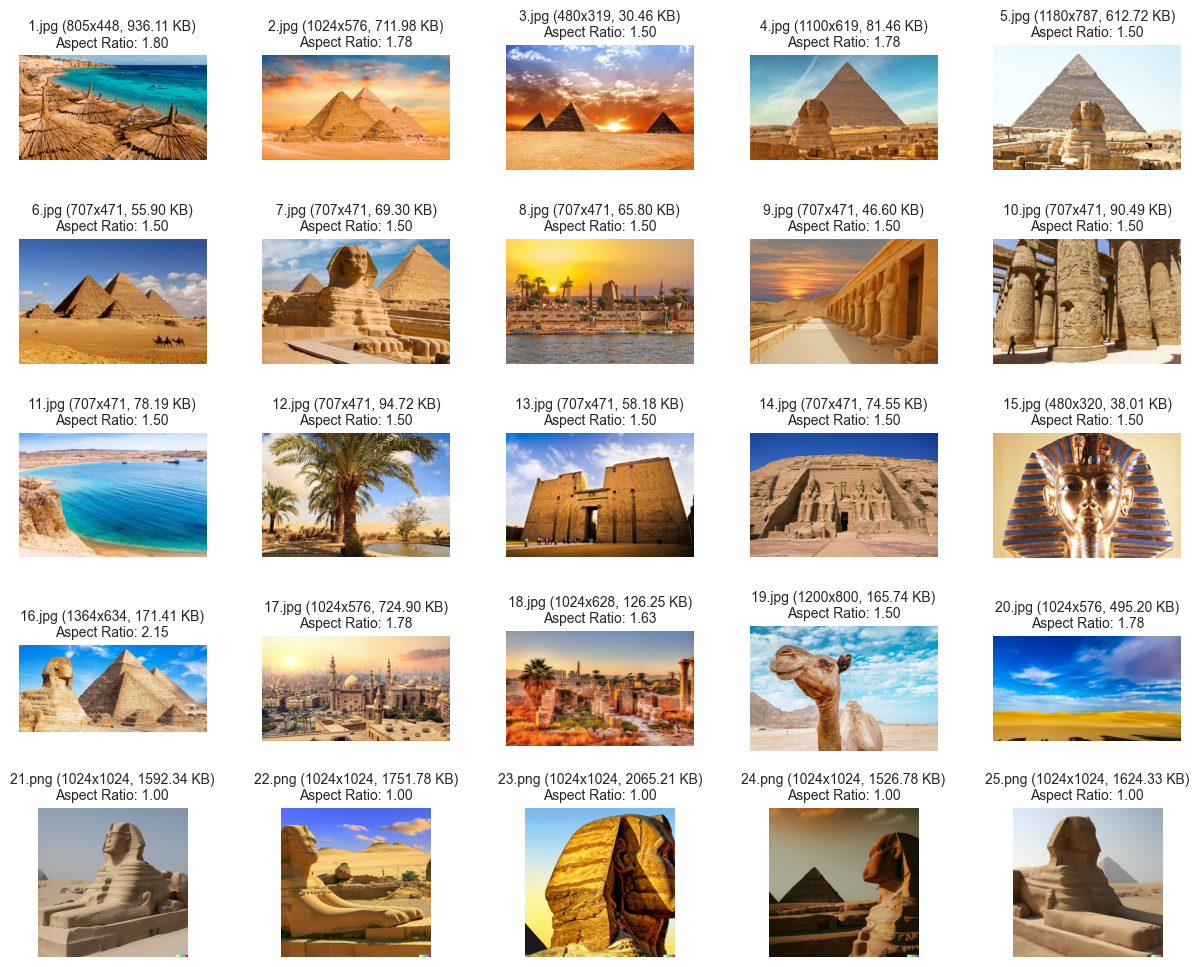

In [108]:
# List of picture filenames
dateinamen = ["1.jpg", "2.jpg", "3.jpg", "4.jpg", "5.jpg", "6.jpg", "7.jpg", "8.jpg", "9.jpg", "10.jpg", "11.jpg", "12.jpg", "13.jpg", "14.jpg", "15.jpg", "16.jpg", "17.jpg", "18.jpg", "19.jpg", "20.jpg", "21.png", "22.png", "23.png", "24.png", "25.png"]

# Create a list to store the images
images = []

# Loop through the filenames and read and store the images in the list
for dateiname in dateinamen:
    # Read the image using PIL
    image = Image.open(f"data/images/{dateiname}")
    images.append(image)

# Create a 5x5 grid for the subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 12))

# Loop through the images and display them with titles
for i, image in enumerate(images):
    # Get image size in pixels
    width, height = image.size

    # Get file size in kilobytes
    file_size_kb = os.path.getsize(f"data/images/{dateinamen[i]}") / 1024

    # Calculate aspect ratio
    aspect_ratio = width / height

    # Choose the appropriate subplot for the current image
    ax = axes[i // 5, i % 5]

    # Display the image on the subplot
    ax.imshow(image)
    ax.axis('off')  # Turn off axis labels

    # Create a title with file name, resolution, and file size
    title = f"{dateinamen[i]} ({width}x{height}, {file_size_kb:.2f} KB)"
    
    # Add the aspect ratio on a new line below the title
    title += f"\nAspect Ratio: {aspect_ratio:.2f}"
    ax.set_title(title, fontsize=10) # set ax title

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Set Seaborn style
sns.set_style("whitegrid")

# Show the plot
plt.show()



### 1.1.2 Bilder selektieren & geeignete Metriken

Wir selektieren für jedes Experiment zwei Bilder und messen die geeigneten Bildmetriken im verlaufe der Experimente. 
Hier schreiben wir die Funktionen die wir dafür benötigen.

Folgende Metriken werden als geeignet erachtet: 
- `RMSE` - Root Mean Square Error - Ein Vergleich der Pixelwerte zwischen zwei Bildern.   
- `PSNE` - Peak Signal-to-Noise Ratio - Ein Vergleich der Pixelwerte zwischen zwei Bildern.   
(Von Skimage-metrics)   
- Die `Histogramme` der Bilder mit dem Parameter log=True, um die Verteilung der Pixelwerte vor und nach der Bearbeitung zu sehen. 

In [ ]:
# Select images for experiment
image_pixel = ["2.jpg", "21.png"]
image_schaerfe = ["10.jpg", "19.jpg"]
image_farbraum = ["11.jpg", "22.png"]

# Visualize images in 3x2 grid 
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
for i, image in enumerate(image_pixel + image_schaerfe + image_farbraum):
    ax = axes[i // 2, i % 2]
    ax.imshow(Image.open(f"data/images/{image}"))
    ax.axis('off')
    ax.set_title(image, fontsize=10)
plt.subplots_adjust(wspace=0, hspace=0.1)
sns.set_style("whitegrid")
plt.suptitle("Bilderauswahl für die Experimente \n Wertebereich von Pixeln, Schärfe, Farbräume", fontsize=20)
plt.show()



In [107]:
# Define rmse metric
def calc_rmse_images(image1, image2):
    """
    Calculate the Root Mean Square Error (RMSE) between two images.

    Parameters:
    image1 (numpy array): The first image represented as a numpy array
    image2 (numpy array): The second image represented as a numpy array

    Returns:
    float: The RMSE between the two images
    """
    # Check if both images have the same shape
    if image1.shape != image2.shape:
        raise ValueError("Both images must have the same shape")

    # Calculate the RMSE
    rmse = np.sqrt(np.mean((image1 - image2)**2))
    return rmse

# create image and histogram comparison function
def image_and_histo(image1, image2, title1, title2, log_scale=False):
    """
    Plots two images and their RGB histograms in a 2x2 subplot each.

    Parameters:
    - image1, image2: 3D numpy arrays representing RGB images.
    - title1, title2: Titles for the subplots of image1 and image2 respectively.
    - log_scale: Boolean. If True, sets the y-axis of the histogram to logarithmic scale.
    """
    
    # Helper function to plot RGB histogram for an image
    def plot_rgb_histogram(ax, img, log_scale):
        colors = ('r', 'g', 'b')
        total_pixels = img.shape[0] * img.shape[1]
        for i, color in enumerate(colors):
            histogram, bin_edges = np.histogram(
                img[:, :, i], 
                bins=256, 
                range=(0, 255)
            )
            normalized_histogram = histogram / total_pixels  # Normalize histogram
            ax.plot(bin_edges[0:-1], 
                    normalized_histogram, 
                    color=color)
        if log_scale:
            ax.set_yscale('log')  # Set logarithmic scale on y-axis
        ax.set_xlim([0, 255])

    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    
    # Display image1
    axs[0, 0].imshow(image1)
    axs[0, 0].set_title(title1)

    # Plot RGB histogram for image1
    plot_rgb_histogram(axs[0, 1], image1, log_scale)
    axs[0, 1].set_title(f"{'Log-Scaled ' if log_scale else ''}RGB Histogram for {title1}")

    # Display image2
    axs[1, 0].imshow(image2)
    axs[1, 0].set_title(title2)

    # Plot RGB histogram for image2
    plot_rgb_histogram(axs[1, 1], image2, log_scale)
    axs[1, 1].set_title(f"{'Log-Scaled ' if log_scale else ''}RGB Histogram for {title2}")

    plt.tight_layout()
    plt.show()

### 1.1.3 Ziel definieren

Einige Eigenschaften, wie Aspect Ratio und Dateigrösse wurden in der Visualisierung von 1.1.1 bereits betrachtet und mit dem Bild visualisiert. Weiter haben wir im Abschnitt 1.1.2 Bilder für unsere Experimente ausgewählt sowie die geeigneten Metriken definiert und Funktionen dafür geschrieben.

Hier definieren wir nun unsere Ziele der verschiedenen Experimente. 

| Experiment | Ziel | Bilder |
| --- | --- | --- |
| Wertebereich von Pixeln | Auf einzelne Pixel Addition und Subtraktion durchführen können. <br> Wertebereich von Bildern Filtern zu können | 2, 21 |
| Schärfe | Bild schärfer und unscharf machen zu können. | 10, 19 |
| Farbräume (Korrektur oder Transformationen) | Helligkeit eines Bildes ändern können. <br> Kontrast eines Bildes verändern. | 11, 22 | 


### 1.1.4 Experiment Wertebereich von Pixeln

In diesem Experiment versuchen wir den Wertebereich des Bildes zu ändern. Dabei versuchen wir in einem ersten Exerperiment durch Addition und Subtraktion der Bilder 2 und 21 das Bild zu verändern und vergleichen anschliessend beide Resultate miteinandner.  


#### 1.1.4.1 Experiment durch Addition / Subtraktion

Wir schreiben eine Funktion, die es uns erlaubt, eine beliebige Zahl auf die Pixelwerte des Bildes zu addieren.   
Pixelwerte die über 255 werden auf 255 geclippt und Pixelwerte die unter 0 fallen werden auf 0 geclippt.   
Die Funktion sollte uns die Möglichkeit geben, auszuwählen, welchen Farbkanal wir verändern möchten.

In [ ]:
def change_value_range(image: np.ndarray, add_r: int, add_g: int, add_b: int) -> np.ndarray:
    """
    Ändert den Wertebereich eines Bildes, indem es eine bestimmte Zahl zu den Pixelwerten der einzelnen Farbkanäle addiert.
    
    Parameters:
    image (np.ndarray): Das Eingabebild als Numpy-Array mit Form (Höhe, Breite, 3).
    add_r (int): Der zu addierende Wert für den Rotkanal.
    add_g (int): Der zu addierende Wert für den Grünkanal.
    add_b (int): Der zu addierende Wert für den Blaukanal.
    
    Returns:
    np.ndarray: Das bearbeitete Bild.
    """
    # Überprüfen, ob das Bild die korrekte Form hat
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError("Das Eingabebild muss die Form (Höhe, Breite, 3) haben.")
    
    # Erstellen einer Kopie des Bildes, um das Originalbild nicht zu verändern
    new_image = image.copy().astype(np.int16)  # Konvertieren zu int16
    
    # Addieren der Werte zu den entsprechenden Kanälen
    new_image[:, :, 0] += add_r  # Rotkanal
    new_image[:, :, 1] += add_g  # Grünkanal
    new_image[:, :, 2] += add_b  # Blaukanal
    
    # Clipping der Pixelwerte, um sicherzustellen, dass sie im gültigen Bereich bleiben
    np.clip(new_image, 0, 255, out=new_image)
    
    # Konvertieren zurück zu uint8
    new_image = new_image.astype(np.uint8)

    # Rückgabe des bearbeiteten Bildes
    return Image.fromarray(new_image)

In [ ]:
# Wertebereich der Pixel manipulieren
image_2_1 = change_value_range(image = np.array(Image.open("data/images/2.jpg")), 
                               add_r=100, 
                               add_g=100, 
                               add_b=100)

image_2_2 = change_value_range(image = np.array(Image.open("data/images/2.jpg")),
                                add_r=-100,
                                add_g=-100,
                                add_b=-100)

image_21_1 = change_value_range(image = np.array(Image.open("data/images/21.png")),
                                add_r=150,
                                add_g=150,
                                add_b=150)

image_21_2 = change_value_range(image = np.array(Image.open("data/images/21.png")),
                                add_r=-150,
                                add_g=-150,
                                add_b=-150)

# Calculate MSE for the images 
rmse_2_1 = calc_rmse_images(image1 = np.array(Image.open("data/images/2.jpg")), image2 = np.array(image_2_1))
rmse_2_2 = calc_rmse_images(image1 = np.array(Image.open("data/images/2.jpg")), image2 = np.array(image_2_2))
rmse_21_1 = calc_rmse_images(image1 = np.array(Image.open("data/images/21.png")), image2 = np.array(image_21_1))
rmse_21_2 = calc_rmse_images(image1 = np.array(Image.open("data/images/21.png")), image2 = np.array(image_21_2))
# calculate MSE for orginal image
rmse_2 = calc_rmse_images(image1 = np.array(Image.open("data/images/2.jpg")), image2 = np.array(Image.open("data/images/2.jpg")).copy())
rmse_21 = calc_rmse_images(image1 = np.array(Image.open("data/images/21.png")), image2 = np.array(Image.open("data/images/21.png")).copy())

# Calculate PSNR for the images
psnr_2_1 = peak_signal_noise_ratio(np.array(Image.open("data/images/2.jpg")), np.array(image_2_1))
psnr_2_2 = peak_signal_noise_ratio(np.array(Image.open("data/images/2.jpg")), np.array(image_2_2))
psnr_21_1 = peak_signal_noise_ratio(np.array(Image.open("data/images/21.png")), np.array(image_21_1))
psnr_21_2 = peak_signal_noise_ratio(np.array(Image.open("data/images/21.png")), np.array(image_21_2))
# calculate psnr for orginal image
psnr_2 = peak_signal_noise_ratio(np.array(Image.open("data/images/2.jpg")), np.array(Image.open("data/images/2.jpg")).copy())
psnr_21 = peak_signal_noise_ratio(np.array(Image.open("data/images/21.png")), np.array(Image.open("data/images/21.png")).copy())

# visualize images in 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
axes[0, 1].imshow(Image.open("data/images/2.jpg"))
axes[0, 1].axis('off')
axes[0, 1].set_title(f"Originalbild \nRMSE: {rmse_2:.2f}, PSNR: {psnr_2:.2f}" , fontsize=10)
axes[0, 2].imshow(image_2_1)
axes[0, 2].axis('off')
axes[0, 2].set_title(f"Pixelwerte +100\nRMSE: {rmse_2_1:.2f}, PSNR: {psnr_2_1:.2f}", fontsize=10)
axes[0, 0].imshow(image_2_2)
axes[0, 0].axis('off')
axes[0, 0].set_title(f"Pixelwerte -100\nRMSE: {rmse_2_2:.2f}, PSNR: {psnr_2_2:.2f}", fontsize=10)
axes[1, 1].imshow(Image.open("data/images/21.png"))
axes[1, 1].axis('off')
axes[1, 1].set_title(f"Originalbild \nRMSE: {rmse_21:.2f}, PSNR: {psnr_21:.2f}", fontsize=10)
axes[1, 2].imshow(image_21_1)
axes[1, 2].axis('off')
axes[1, 2].set_title(f"Pixelwerte +150\nRMSE: {rmse_21_1:.2f}, PSNR: {psnr_21_1:.2f}", fontsize=10)
axes[1, 0].imshow(image_21_2)
axes[1, 0].axis('off')
axes[1, 0].set_title(f"Pixelwerte -150\nRMSE: {rmse_21_2:.2f}, PSNR: {psnr_21_2:.2f}", fontsize=10)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
sns.set_style("whitegrid")
plt.suptitle("Pixelwerte verändern", fontsize=20, y=0.9)
plt.tight_layout()
plt.show()



In [ ]:
# Histogramm der Bilder
image_and_histo(image1=np.array(Image.open("data/images/2.jpg")), 
                image2=np.array(image_2_1), 
                title1="Originalbild", 
                title2="Pixelwerte +100",
                log_scale=True)

image_and_histo(image1=np.array(Image.open("data/images/2.jpg")),
                image2=np.array(image_2_2),
                title1="Originalbild",
                title2="Pixelwerte -100", 
                log_scale=True)

image_and_histo(image1=np.array(Image.open("data/images/21.png")),
                image2=np.array(image_21_1),
                title1="Originalbild",
                title2="Pixelwerte +150",
                log_scale=True)

image_and_histo(image1=np.array(Image.open("data/images/21.png")),
                image2=np.array(image_21_2),
                title1="Originalbild",
                title2="Pixelwerte -150",
                log_scale=True)

#### 1.1.4.2 Diskussion

Datenwahl:   
Bei den Daten handelt es sicht um das Bild 2 und 21. Das Bild 2 wurde bewusst für diese Aufgabe gewählt, da dieses Bild sehr bunt aussieht und viele Farben aufweist. Das Bild 21, ist ein von Dall-E 2 generiertes Bild, welches nicht besoners lebendig aussieht. Beide Bilder wurden gewählt, um zu sehen, was für einen Effekt die Addition und Subtraktion auf die unterschiedlichen Arten von Bilder haben.

Parameterwahl:   
Die Funktion `change_value_range` erlaubt es uns für jeden Farbchannel, eine beliebige Zahl auf die Pixelwerte des Bildes zu addieren oder zu subtrahieren. Alternativ hätte man zu allen Farbkanälen die gleiche Zahl addieren oder subtrahieren können. Dies kann man jedoch immer noch tun, indem man die gleiche Zahl für jeden Farbchannel addiert oder subtrahiert. 

Methodenwahl:   
Bei der Methodenwahl überprüfen wir, ob das Bild zuerst 3 Farbkanäle aufweist (Höhe, Breite, Farbkanäle) anschliessend erstellen wir eine Kopie des Bildes, um das Orginal Bild nicht unbewusst zu verändern und führen dann eine Addition oder Sutraktion durch. Dabei stellen wir auch sicher, dass die Pixelwerte nicht über 255 oder unter 0 fallen, da wir sonst nicht im RGB Pixelwertebereich sind. 

Erzielte Ergebnisse:   
Addiert man zu jedem Pixelchannel eine grosse Zahl, so verschiebt sich jedes Farbspektrum weiter nach Rechts, Richtung 255 und das Bild wird heller bzw. hat einen grössseren Anteil an der Farbe Weiss. Wonhingegen eine Subtraktion, sprich eine verschiebung nach Links, Richtung 0 das Bild dünkler aussehen lässt. In einem Extrem Fall er Addition/SUbtraktion erhalten wir ein komplett schwarzes oder weisses Bild. Beim Histogramm ersichtlich sehen wir die Verschiebung der Addition oder Subtraktion entsprechend dem addierten oder subtrahierten Wert. 


#### 1.1.4.3 Experiment durch Filtern 

Die Idee in diesem Experiment ist es nach einen bestimmten Pixel Wertebereich zu filtern und anschliessend die Bilder zu visualisieren und zu vergleichen.

Auch hier schreiben wir eine Funktion, die es uns ermöglicht, die Filterung auf die einzelnen Farbkanäle anzuwenden. Um zu überprüfen, ob die Filterung funktioniert, filtern wir den Farbkanal Rot mit einem Wertebereich von 0 bis 0, also bzw eine Entfernung und erwarten ein Bild mit blau und grün tönen. 

In [ ]:
def filter_pixel_values(image_path, filter_r, filter_g, filter_b):
    # Bild einlesen
    image = Image.open(image_path)
    
    # Umwandeln in ein Numpy-Array
    img_array = np.array(image)

    # Überprüfen, ob das Bild die korrekte Form hat
    if img_array.ndim != 3 or img_array.shape[2] != 3:
        raise ValueError("Das Eingabebild muss die Form (Höhe, Breite, 3) haben.")
    
    # Pixelwerte filtern
    red_channel = np.where((img_array[:,:,0] >= filter_r[0]) & (img_array[:,:,0] <= filter_r[1]), img_array[:,:,0], 0)
    green_channel = np.where((img_array[:,:,1] >= filter_g[0]) & (img_array[:,:,1] <= filter_g[1]), img_array[:,:,1], 0)
    blue_channel = np.where((img_array[:,:,2] >= filter_b[0]) & (img_array[:,:,2] <= filter_b[1]), img_array[:,:,2], 0)
    
    # Set correct dtype for image array
    filtered_img_array = np.stack([red_channel, green_channel, blue_channel], axis=2).astype(np.uint8)
    
    # Bild aus gefiltertem Array erstellen
    filtered_image = Image.fromarray(filtered_img_array)
    
    # Return filtered image
    return filtered_image

In [ ]:
# Funktion testen indem Rot weg gefiltert wird
image_2_1_filter = filter_pixel_values(image_path='data/images/2.jpg', 
                                       filter_r = (0, 0), 
                                       filter_g = (0, 255), 
                                       filter_b = (0, 255))

image_2_2_filter = filter_pixel_values(image_path='data/images/2.jpg',
                                        filter_r = (0, 255),
                                        filter_g = (0, 0),
                                        filter_b = (0, 255))

image_21_1_filter = filter_pixel_values(image_path='data/images/21.png',
                                        filter_r = (0, 0),
                                        filter_g = (0, 255),
                                        filter_b = (0, 255))

image_21_2_filter = filter_pixel_values(image_path='data/images/21.png',
                                        filter_r = (0, 255),
                                        filter_g = (0, 0),
                                        filter_b = (0, 255))

# Calculate MSE for the images
rmse_2_1_filter = calc_rmse_images(image1 = np.array(Image.open("data/images/2.jpg")), image2 = np.array(image_2_1_filter))
rmse_2_2_filter = calc_rmse_images(image1 = np.array(Image.open("data/images/2.jpg")), image2 = np.array(image_2_2_filter))
rmse_21_1_filter = calc_rmse_images(image1 = np.array(Image.open("data/images/21.png")), image2 = np.array(image_21_1_filter))
rmse_21_2_filter = calc_rmse_images(image1 = np.array(Image.open("data/images/21.png")), image2 = np.array(image_21_2_filter))

# Calculate PSNR for the images
psnr_2_1_filter = peak_signal_noise_ratio(np.array(Image.open("data/images/2.jpg")), np.array(image_2_1_filter))
psnr_2_2_filter = peak_signal_noise_ratio(np.array(Image.open("data/images/2.jpg")), np.array(image_2_2_filter))
psnr_21_1_filter = peak_signal_noise_ratio(np.array(Image.open("data/images/21.png")), np.array(image_21_1_filter))
psnr_21_2_filter = peak_signal_noise_ratio(np.array(Image.open("data/images/21.png")), np.array(image_21_2_filter))

# visualize images in 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
axes[0, 1].imshow(Image.open("data/images/2.jpg"))
axes[0, 1].axis('off')
axes[0, 1].set_title(f"Originalbild \nRMSE: {rmse_2:.2f}, PSNR: {psnr_2:.2f}" , fontsize=10)
axes[0, 2].imshow(image_2_1_filter)
axes[0, 2].axis('off')
axes[0, 2].set_title(f"Rotkanal gefiltert\nRMSE: {rmse_2_1_filter:.2f}, PSNR: {psnr_2_1_filter:.2f}", fontsize=10)
axes[0, 0].imshow(image_2_2_filter)
axes[0, 0].axis('off')
axes[0, 0].set_title(f"Grünkanal gefiltert\nRMSE: {rmse_2_2_filter:.2f}, PSNR: {psnr_2_2_filter:.2f}", fontsize=10)
axes[1, 1].imshow(Image.open("data/images/21.png"))
axes[1, 1].axis('off')
axes[1, 1].set_title(f"Originalbild \nRMSE: {rmse_21:.2f}, PSNR: {psnr_21:.2f}", fontsize=10)
axes[1, 2].imshow(image_21_1_filter)
axes[1, 2].axis('off')
axes[1, 2].set_title(f"Rotkanal gefiltert\nRMSE: {rmse_21_1_filter:.2f}, PSNR: {psnr_21_1_filter:.2f}", fontsize=10)
axes[1, 0].imshow(image_21_2_filter)
axes[1, 0].axis('off')
axes[1, 0].set_title(f"Grünkanal gefiltert\nRMSE: {rmse_21_2_filter:.2f}, PSNR: {psnr_21_2_filter:.2f}", fontsize=10)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
sns.set_style("whitegrid")
plt.suptitle("Rotkanal & Grünkanal filtern", fontsize=20, y=0.9)
plt.tight_layout()
plt.show()


In [ ]:
# Histogramm der Bilder
image_and_histo(image1=np.array(Image.open("data/images/2.jpg")),
                image2=np.array(image_2_1_filter),
                title1="Originalbild",
                title2="Rotkanal gefiltert",
                log_scale=True)

image_and_histo(image1=np.array(Image.open("data/images/2.jpg")),
                image2=np.array(image_2_2_filter),
                title1="Originalbild",
                title2="Grünkanal gefiltert",
                log_scale=True)

image_and_histo(image1=np.array(Image.open("data/images/21.png")),
                image2=np.array(image_21_1_filter),
                title1="Originalbild",
                title2="Rotkanal gefiltert",
                log_scale=True)

image_and_histo(image1=np.array(Image.open("data/images/21.png")),
                image2=np.array(image_21_2_filter),
                title1="Originalbild",
                title2="Grünkanal gefiltert",
                log_scale=True)


#### 1.1.4.4 Diskussion

Datenwahl:   
Siehe Beschreibung 1.1.4.2  

Parameterwahl:   
Die Funktion `filter_value_range` erlaubt es uns für jeden Farbchannel, einen Wertebereich zu definieren, auf den gefiltert werden soll, dies erlaubt es uns bestimmte Pixelwerte zu entfernen und auszuwählen. Bsp. die komplete Entfernung vom Farbkanal rot oder Teiletnfernung vom Farbkanal Grün.

Methodenwahl:   
Analog wie beim vorherhigen Experiment, überprüfen wir die Dimension des Bildes. Anschliessend wird jeder Farbkanal gefiltert und anschliessend wieder in der gleichen Reihenfolge wieder zusammen gefügt zu einer grossen 3-D Matrix. 

Erzielte Ergebnisse:   
Das Experiment hat funktioniert, es ist möglich mit unserer geschriebenen Funktion einen kompletten Farbkanal zu eliminieren. Dies erkennen wir auch in unserem Histogramm, indem eine ganze Farblinie fehlt. Die Bilder sehen entsprechend auch anders aus, da die Farbe Rot komplett entfernt wurde, bleiben nur die Farbkanäle Grün und Blau übrig, welches ein Bild mit grün und blau tönen ergibt. Analog dafür wenn wir von einem Bild den Farbkanal Grün eliminieren erhalten wir ein Bild mit Rot und Blau tönen. Beim Bild 2, durch das eliminieren vom Grünkanal erkennen wir, dass im Originalbild grün enthalten ist für die Orange Farbe sowie für das Hellblaue verantwortlich ist.

### 1.1.5 Experiment Schärfe

In Experiment Schärfe, versuchen wir einerseits das Bild mittels Filtern (Kernel) zu schärfen. 
Weiter versuchen wir auch, die Bilder mittels einer selbst implementierten Gausschen Weichzeichenfilter zu verschwimmen und schauen uns die Resultate dann an. 

#### 1.1.5.1 Experiment durch Filter

Wir schreiben eine Funktion, die es uns erlaubt, ein beliebiges Bild mit einem beliebigen Filter der Wahl zu filtern, um somit die Schärfe des Bildes zu erhöhen oder zu verringern und schauen, ob das Resultat unseren Erwartungen entspricht.

In [ ]:
# Implementierung der Convulution Filter
def convolve2D(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    Convolves an image with a kernel.

    Parameters:
    image (np.ndarray): Input image (2D array).
    kernel (np.ndarray): Kernel (2D array).

    Returns:
    np.ndarray: Convolved image.
    """
    # Get the dimensions of the image and the kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    # Allocate space for the output image
    output = np.zeros_like(image, dtype=float)

    # Compute the padding size for the image
    pad_height = (kernel_height - 1) // 2
    pad_width = (kernel_width - 1) // 2

    # Pad the image with zeros
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    # Perform convolution
    for y in range(image_height):
        for x in range(image_width):
            region = padded_image[y:y + kernel_height, x:x + kernel_width]
            output[y, x] = np.sum(region * kernel)

    return output
# CHATGPT

def image_sharpness(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    Sharpens an image using a specified convolution kernel.
    
    Parameters:
    image (np.ndarray): The input image as a Numpy array with shape (height, width, 3).
    kernel (np.ndarray): The convolution kernel used for image sharpening.

    Returns:
    np.ndarray: The sharpened image.
    """
    # Ensure image has the correct shape
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError("The input image must have the shape (height, width, 3).")
    
    # Initialize the output image
    sharpened = np.zeros_like(image, dtype=np.float32)

    # Apply the convolution kernel to each channel separately
    for channel in range(3):
        sharpened[:, :, channel] = convolve2D(image[:, :, channel].astype(float), kernel)
    
    # Clip values to be in the valid range and convert back to uint8
    np.clip(sharpened, 0, 255, out=sharpened)
    sharpened = sharpened.astype(np.uint8)
    
    return sharpened

In [ ]:
# test functino image_sharpness
# Create a sharpening kernel
kernel = np.array([[-1, -1, -1],
                   [-1,  9, -1],
                   [-1, -1, -1]])

# Apply the kernel to the image
image_10_sharp = image_sharpness(image=np.array(Image.open("data/images/10.jpg")), 
                                 kernel=np.array([[-1, -1, -1],
                                                  [-1,  9, -1],
                                                  [-1, -1, -1]]))

image_19_sharp = image_sharpness(image=np.array(Image.open("data/images/19.jpg")),
                                    kernel=np.array([[-1, -1, -1],
                                                    [-1,  9, -1],
                                                    [-1, -1, -1]]))


In [ ]:
# Calculate MSE for the images
rmse_10_sharp = calc_rmse_images(image1 = np.array(Image.open("data/images/10.jpg")), image2 = np.array(image_10_sharp))
rmse_19_sharp = calc_rmse_images(image1 = np.array(Image.open("data/images/19.jpg")), image2 = np.array(image_19_sharp))

# calculate MSE for orginal image
rmse_10 = calc_rmse_images(image1 = np.array(Image.open("data/images/10.jpg")), image2 = np.array(Image.open("data/images/10.jpg")).copy())
rmse_19 = calc_rmse_images(image1 = np.array(Image.open("data/images/19.jpg")), image2 = np.array(Image.open("data/images/19.jpg")).copy())

# Calculate PSNR for the images
psnr_10_sharp = peak_signal_noise_ratio(np.array(Image.open("data/images/10.jpg")), np.array(image_10_sharp))
psnr_19_sharp = peak_signal_noise_ratio(np.array(Image.open("data/images/19.jpg")), np.array(image_19_sharp))
# calculate psnr for orginal image
psnr_10 = peak_signal_noise_ratio(np.array(Image.open("data/images/10.jpg")), np.array(Image.open("data/images/10.jpg")).copy())
psnr_19 = peak_signal_noise_ratio(np.array(Image.open("data/images/19.jpg")), np.array(Image.open("data/images/19.jpg")).copy())

# visualize images in 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes[0, 0].imshow(Image.open("data/images/10.jpg"))
axes[0, 0].axis('off')
axes[0, 0].set_title(f"Originalbild\nRMSE: {rmse_10:.2f}, PSNR: {psnr_10:.2f}", fontsize=10)
axes[0, 1].imshow(image_10_sharp)
axes[0, 1].axis('off')
axes[0, 1].set_title(f"Sharpness\nRMSE: {rmse_10_sharp:.2f}, PSNR: {psnr_10_sharp:.2f}", fontsize=10)

axes[1, 0].imshow(Image.open("data/images/19.jpg"))
axes[1, 0].axis('off')
axes[1, 0].set_title(f"Originalbild\nRMSE: {rmse_19:.2f}, PSNR: {psnr_19:.2f}", fontsize=10)
axes[1, 1].imshow(image_19_sharp)
axes[1, 1].axis('off')
axes[1, 1].set_title(f"Sharpness\nRMSE: {rmse_19_sharp:.2f}, PSNR: {psnr_19_sharp:.2f}", fontsize=10)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
sns.set_style("whitegrid")
plt.suptitle("Bildschärfe", fontsize=20, y=1)
plt.tight_layout()
plt.show()


In [ ]:
# Histogramm der Bilder
image_and_histo(image1=np.array(Image.open("data/images/10.jpg")),
                image2=np.array(image_10_sharp),
                title1="Originalbild",
                title2="Geschärftes Bild",
                log_scale=True)

image_and_histo(image1=np.array(Image.open("data/images/19.jpg")),
                image2=np.array(image_19_sharp),
                title1="Originalbild",
                title2="Geschärftes Bild",
                log_scale=True)



#### 1.1.5.2 Diskussion

Datenwahl:   
Bei der Wahl der Bilder wurden bewusst Bilder genommen, welches Muster aufweisen, wie bei Bild 10, ein Bild indem Hyroglyphen in Stein gemeisselt wurden. Das zweite Bild, Bild 19, ist ein Bild, welches ein Lama zeigt, welches in der Wüste steht. Auch dieses Bild wurde gewählt, da ganz ganz feine Haarstrukturen beim Lama zu erkennen sind und ich gespannt war, ob ich die Hyrogphylphen und die Haarstrukturen mit dem Schärfen Experiment besser erkennen kann.

Parameterwahl:   
Bei der Parameterwahl haben wir einen kernel, sprich ein Filter, welches uns erlaubt das Bild zu Filtern. Dieser Filter ist ein 3x3 Filter, welches die Schärfe des Bildes erhöhen soll.

Methodenwahl:
Für die Schärfung eines Bildes wurde die Funktion `convolve2D` & `image_sharpness` implementiert. Die Funktion `convolve2D` erweitert das Bild mit Nullen am Rand (padding) und wendet anschliessend den Filter auf das Bild an. Dabei wird für jeder Punkt im Bild ein neuer Wert berechnet indem der Filterkern mit dem überdeckten Bildpunkten elementweise multipliziert und anschliessend aufsummiert wird. Die Funktion `image_sharpness` stellt die Dimension des Bildes sicher und wendet die Funktion `convolve2D` auf jeden Farbchannel einzeln an. Werte die kleiner als 0 oder grösser als 255 sind, werden auf 0 oder 255 geclippt.

Erzielte Ergebnisse:   
Das Experiment hat funktioniert, es ist möglich mit unserer geschriebenen Funktion ein Bild zu schärfen. Wir erkennen nun die Hyroglphen im Bild mit einer stärkeren schwarzen Linie. Auch die Haarstrukturen des Lamas sind nun besser zu erkennen und wir sehen, dass das Lama überall im Gesicht Haare aufweist. Ein Haar, welches man im Orginalbild nicht erkennt, sieht man ebenfalls im geschärften Bild (Haare unter dem linken Nasenloch). Beim Histogramm erkennen wir, dass sich die y-Achsen Skala deutlich nach unten verschoben hat, was bedeutet, dass die Pixelwerte nun weniger vertreten sind. Wir sehen bei 0 und 255 einen deutlichen Peak, das bedeutet, dass sehr viele Werte unter 0 oder über 255 waren und gecleipt wurden.


#### 1.1.5.3 Experiment mit Gausschen Weichzeichenfilter

Auch hier schreiben wir eine Funktion, analog der vorherhigen, einfach das die Filterwerte durch eine Normalverteilung generiert werden und erhoffen uns somit ein verschwommenes Bil zu erhalten.

In [ ]:
def gaussian_kernel(size: int, sigma: float):
    """Generates a Gaussian kernel."""
    kernel = np.fromfunction(lambda x, y: (1/ (2 * np.pi * sigma ** 2)) * 
                             np.exp(- ((x - (size - 1) / 2) ** 2 + (y - (size - 1) / 2) ** 2) / (2 * sigma ** 2)),
                             (size, size))
    return kernel / np.sum(kernel)
# CHATGPT

def gaussian_filter(image: np.ndarray, sigma: float) -> np.ndarray:
    """Applies a Gaussian filter to an image."""
    size = int(6 * sigma + 1)
    size = size + 1 if size % 2 == 0 else size  # size must be odd
    kernel = gaussian_kernel(size, sigma)
    return convolve2D(image, kernel)
# CHATGPT

def blurry_image(image: np.ndarray, sigma: float) -> np.ndarray:
    """
    Blurs an image using a specified sigma value for the Gaussian filter.
    
    Parameters:
    image (np.ndarray): The input image as a Numpy array with shape (height, width, 3).
    sigma (float): The sigma value used for the Gaussian blur.

    Returns:
    np.ndarray: The blurred image.
    """
    # Ensure image has the correct shape
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError("The input image must have the shape (height, width, 3).")
    
    # Initialize the output image
    blurred = np.zeros_like(image, dtype=np.float32)

    # Apply the Gaussian filter to each channel separately
    for channel in range(3):
        blurred[:, :, channel] = gaussian_filter(image[:, :, channel].astype(float), sigma)
    
    # Clip values to be in the valid range and convert back to uint8
    np.clip(blurred, 0, 255, out=blurred)
    blurred = blurred.astype(np.uint8)
    
    return blurred

In [ ]:
# test function blurry_image
# Apply the kernel to the image
image_10_blurry = blurry_image(image=np.array(Image.open("data/images/10.jpg")), 
                               sigma=2.0)

image_19_blurry = blurry_image(image=np.array(Image.open("data/images/19.jpg")),
                               sigma=5.0)

# Calculate MSE for the images
rmse_10_blurry = calc_rmse_images(image1 = np.array(Image.open("data/images/10.jpg")), image2 = np.array(image_10_blurry))
rmse_19_blurry = calc_rmse_images(image1 = np.array(Image.open("data/images/19.jpg")), image2 = np.array(image_19_blurry))

# Calculate PSNR for the images
psnr_10_blurry = peak_signal_noise_ratio(np.array(Image.open("data/images/10.jpg")), np.array(image_10_blurry))
psnr_19_blurry = peak_signal_noise_ratio(np.array(Image.open("data/images/19.jpg")), np.array(image_19_blurry))


# visualize images in 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes[0, 0].imshow(Image.open("data/images/10.jpg"))
axes[0, 0].axis('off')
axes[0, 0].set_title(f"Originalbild\nRMSE: {rmse_10:.2f}, PSNR: {psnr_10:.2f}", fontsize=10)
axes[0, 1].imshow(image_10_blurry)
axes[0, 1].axis('off')
axes[0, 1].set_title(f"Verwischtes Bild\nRMSE: {rmse_10_blurry:.2f}, PSNR: {psnr_10_blurry:.2f}", fontsize=10)

axes[1, 0].imshow(Image.open("data/images/19.jpg"))
axes[1, 0].axis('off')
axes[1, 0].set_title(f"Originalbild\nRMSE: {rmse_19:.2f}, PSNR: {psnr_19:.2f}", fontsize=10)
axes[1, 1].imshow(image_19_blurry)
axes[1, 1].axis('off')
axes[1, 1].set_title(f"Verwischtes Bild\nRMSE: {rmse_19_blurry:.2f}, PSNR: {psnr_19_blurry:.2f}", fontsize=10)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
sns.set_style("whitegrid")
plt.suptitle("Bildunschärfe", fontsize=20, y=1)
plt.tight_layout()
plt.show()


In [ ]:
# Histogramm der Bilder
image_and_histo(image1=np.array(Image.open("data/images/10.jpg")),
                image2=np.array(image_10_blurry),
                title1="Originalbild",
                title2="Verwischtes Bild")

image_and_histo(image1=np.array(Image.open("data/images/19.jpg")),
                image2=np.array(image_19_blurry),
                title1="Originalbild",
                title2="Verwischtes Bild")


#### 1.1.5.4 Diskussion

Datenwahl:   
Beim blurren haben wir die gleichen Bilder genommen wie beim Schärfen, da im Orginalbild Hyroglyphen Muster sowie Haarstrukturen zu erkennen sind. Durch as blurren, müssten wir weniger erkennen.

Parameterwahl:   
Analog wie beim Schräfen, nutzen wir ebenfalls einen Filter, mit dem wir über das Bild gehen und jeden einzelnen Farbchannel verändern.

Methodenwahl:   
Zum blurren nutzen wir einen Gaussian Filter. Die Funktion `gaussian_kernel` hat den Paramater `size` und `sigma`, durch `size` erstellen wir eine quadratische Matrix und mittels `sigma` der Standardabweichung generieren wir Werte die einer Normalverteilung folgen. Die Summe aller Elemente der Kernel Matrix ist 1. Die Funktion `gaussian_filter` stellt die Dimension des Filter grösse Sicher und erstellt einen gaussian_kernel und nutzt anschliessend die von Experiment 1.1.5.1 implementierte Funktion `convolve2D` um das Bild zu blurren.

Erzielte Ergebnisse:   
Die Bilder sind unscharf. Das Experiment hat geklappt. Beide Bilder sind verschwommen und man erkennt weniger Strukturen und Muster, was auch das Ziel des blurren war. Im Histogramm sehen wir, dass der Wertebereich vom blurren sich für jeden Farbchannel erhöht hat.

### 1.1.6 Experiment Farbräume (Korrektur oder Transformationen)

In diesem Experiment versuchen wir eine Helligkeitskorrektur durchzuführen. 
Weiter untersuchen wir die das HSV-Farbmodell und schauen uns die Bilder an, ob diese denn tatsächlich Lebendiger, Reiner sind.

#### 1.1.6.1 Experiment Helligkeitskorrektur

In diesem Experiment versuchen wir die Helligkeit der Bilder zu erhöhen indem wir die Bilder in den LSV-Farbraum konvertieren und anschliessend die Helligkeit (luminance) verändern und schauen uns an, was mit den Bildern geschieht.

In [ ]:
def adjust_brightness_lab(image: np.ndarray, factor: float) -> np.ndarray:
    """
    Adjusts the brightness of an image in the LAB color space.

    Parameters:
    image (np.ndarray): The input image as a Numpy array with shape (height, width, 3).
    factor (float): The factor by which to adjust the brightness in the L channel.
                    A factor of 1.0 means no change. Values can be above or below 1 to increase or decrease brightness, respectively.

    Returns:
    np.ndarray: The image with adjusted brightness.
    """
    # Ensure image has the correct shape and normalize to range [0, 1]
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError("The input image must have the shape (height, width, 3).")
    
    # Convert image to LAB color space
    lab_image = color.rgb2lab(image)
    
    # Adjust the L channel by the specified factor
    lab_image[:, :, 0] = np.clip(lab_image[:, :, 0] * factor, 0, 100)
    
    # Convert back to RGB color space
    rgb_image = color.lab2rgb(lab_image)
    
    # If the original image was uint8, convert back to uint8
    if image.dtype == np.uint8:
        rgb_image = (rgb_image * 255).astype(np.uint8)
    
    return rgb_image


In [ ]:
# test function adjust_brightness_lab
image_11_bright = adjust_brightness_lab(image=np.array(Image.open("data/images/11.jpg")), 
                                        factor=1.5)

image_22_bright = adjust_brightness_lab(image=np.array(Image.open("data/images/22.png")),
                                        factor=0.5)

# Calculate MSE for the images
rmse_11_bright = calc_rmse_images(image1 = np.array(Image.open("data/images/11.jpg")), image2 = np.array(image_11_bright))
rmse_22_bright = calc_rmse_images(image1 = np.array(Image.open("data/images/22.png")), image2 = np.array(image_22_bright))
# calculate MSE for orginal image
rmse_11 = calc_rmse_images(image1 = np.array(Image.open("data/images/11.jpg")), image2 = np.array(Image.open("data/images/11.jpg")).copy())
rmse_22 = calc_rmse_images(image1 = np.array(Image.open("data/images/22.png")), image2 = np.array(Image.open("data/images/22.png")).copy())

# Calculate PSNR for the images
psnr_11_bright = peak_signal_noise_ratio(np.array(Image.open("data/images/11.jpg")), np.array(image_11_bright))
psnr_22_bright = peak_signal_noise_ratio(np.array(Image.open("data/images/22.png")), np.array(image_22_bright))
# calculate psnr for orginal image
psnr_11 = peak_signal_noise_ratio(np.array(Image.open("data/images/11.jpg")), np.array(Image.open("data/images/11.jpg")).copy())
psnr_22 = peak_signal_noise_ratio(np.array(Image.open("data/images/22.png")), np.array(Image.open("data/images/22.png")).copy())

# visualize images in 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes[0, 0].imshow(Image.open("data/images/11.jpg"))
axes[0, 0].axis('off')
axes[0, 0].set_title(f"Originalbild\nRMSE: {rmse_11:.2f}, PSNR: {psnr_11:.2f}", fontsize=10)
axes[0, 1].imshow(image_11_bright)
axes[0, 1].axis('off')
axes[0, 1].set_title(f"Helleres Bild\nRMSE: {rmse_11_bright:.2f}, PSNR: {psnr_11_bright:.2f}", fontsize=10)

axes[1, 0].imshow(Image.open("data/images/22.png"))
axes[1, 0].axis('off')
axes[1, 0].set_title(f"Originalbild\nRMSE: {rmse_22:.2f}, PSNR: {psnr_22:.2f}", fontsize=10)
axes[1, 1].imshow(image_22_bright)
axes[1, 1].axis('off')
axes[1, 1].set_title(f"Helleres Bild\nRMSE: {rmse_22_bright:.2f}, PSNR: {psnr_22_bright:.2f}", fontsize=10)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
sns.set_style("whitegrid")
plt.suptitle("Helligkeit", fontsize=20, y=1)
plt.tight_layout()
plt.show()


In [ ]:
# Histogramm der Bilder
image_and_histo(image1=np.array(Image.open("data/images/11.jpg")),
                image2=np.array(image_11_bright),
                title1="Originalbild",
                title2="Helleres Bild",
                log_scale=False)

image_and_histo(image1=np.array(Image.open("data/images/22.png")),
                image2=np.array(image_22_bright),
                title1="Originalbild",
                title2="Dunkleres Bild",
                log_scale=False)



#### 1.1.6.2 Diskussion

Datenwahl:   
Für die Experimente in den Farbrräumen wurde ein Bild vom See/Meer gewählt und ein von Dall-E generiertes Bild. Beide Bilder wurden gewählt, um zu sehen, was für einen Effekt die Helligkeitskorrektur auf die unterschiedlichen Arten von Bilder haben.

Parameterwahl:   
Die Funktion `adjust_brightness_lab` erlaubt es uns mit dem Parameter `factor` die Helligkeit eines Bildes beliebig zu verändern. Ein factor von 1 verändert das Bild nicht, ein factor kleiner als 1 verdunkelt das Bild und grösser als 1 erhellt das Bild.

Methodenwahl:   
Die Funktion `adjust_brightness_lab` konvertiert das Bild in den LSV-Farbraum und verändert die Luminance des Bildes, indem es jeden Wert im L-Channel mit einem Faktor multipliziert und anschliessend zwischen 0 und 100 (Wertebereich von L) clippt. Anschliessend wird das Bild wieder in den RGB-Farbraum konvertiert.

Erzielte Ergebnisse:   
Das Experiment hat funktioniert, mit der Funktion ist es möglich, ein beliebiges Bild zu erhellen oder zu verdunkeln. Im Histogramm sehen wir, dass die Pixelwerte bei einer Erhöhung der Helligkeit sich nach rechts verschieben und bei einer Verringerung der Helligkeit sich nach links verschieben. Die Bilder sehen entsprechend auch anders aus, da die Helligkeit des Bildes verändert wurde.

#### 1.1.6.3 Experiment HSV-Farbmodell

In diesem Experiment spielen wir mit den Werten von V im HSV-Farbmodell, indem wir einen Histogramm-Equalizer auf den V-Kanal anwenden und schauen uns die Resultate an.

In [ ]:
def adjust_contrast_hsv(image: np.ndarray) -> np.ndarray:
    """
    Adjusts the brightness of an image in the HSV color space using histogram equalization.

    Parameters:
    image (np.ndarray): The input image as a Numpy array with shape (height, width, 3).

    Returns:
    np.ndarray: The image with adjusted brightness.
    """
    # Ensure image has the correct shape
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError("The input image must have the shape (height, width, 3).")

    # Convert image to HSV color space
    hsv_image = color.rgb2hsv(image)
    
    # Apply histogram equalization to the V channel
    hsv_image[:, :, 2] = exposure.equalize_hist(hsv_image[:, :, 2], nbins=256, mask=1)
    
    # Convert back to RGB color space
    rgb_image = color.hsv2rgb(hsv_image)
    
    # Convert back to uint8 if necessary
    if image.dtype == np.uint8:
        rgb_image = (rgb_image * 255).astype(np.uint8)
    
    return rgb_image

In [ ]:
# test function adjust_brightness_lab
image_11_bright = adjust_contrast_hsv(image=np.array(Image.open("data/images/11.jpg")))
image_22_bright = adjust_contrast_hsv(image=np.array(Image.open("data/images/22.png")))

# Calculate MSE for the images
rmse_11_bright = calc_rmse_images(image1 = np.array(Image.open("data/images/11.jpg")), image2 = np.array(image_11_bright))
rmse_22_bright = calc_rmse_images(image1 = np.array(Image.open("data/images/22.png")), image2 = np.array(image_22_bright))

# Calculate PSNR for the images
psnr_11_bright = peak_signal_noise_ratio(np.array(Image.open("data/images/11.jpg")), np.array(image_11_bright))
psnr_22_bright = peak_signal_noise_ratio(np.array(Image.open("data/images/22.png")), np.array(image_22_bright))

# visualize images in 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes[0, 0].imshow(Image.open("data/images/11.jpg"))
axes[0, 0].axis('off')
axes[0, 0].set_title(f"Originalbild\nRMSE: {rmse_11:.2f}, PSNR: {psnr_11:.2f}", fontsize=10)
axes[0, 1].imshow(image_11_bright)
axes[0, 1].axis('off')
axes[0, 1].set_title(f"Kontraständerung\nRMSE: {rmse_11_bright:.2f}, PSNR: {psnr_11_bright:.2f}", fontsize=10)

axes[1, 0].imshow(Image.open("data/images/22.png"))
axes[1, 0].axis('off')
axes[1, 0].set_title(f"Originalbild\nRMSE: {rmse_22:.2f}, PSNR: {psnr_22:.2f}", fontsize=10)
axes[1, 1].imshow(image_22_bright)
axes[1, 1].axis('off')
axes[1, 1].set_title(f"Kontraständerung\nRMSE: {rmse_22_bright:.2f}, PSNR: {psnr_22_bright:.2f}", fontsize=10)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
sns.set_style("whitegrid")
plt.suptitle("Kontraständerung", fontsize=20, y=1)
plt.tight_layout()
plt.show()


In [ ]:
# Histogramm der Bilder
image_and_histo(image1=np.array(Image.open("data/images/11.jpg")),
                image2=np.array(image_11_bright),
                title1="Originalbild",
                title2="Kontraständerung",
                log_scale=True)

image_and_histo(image1=np.array(Image.open("data/images/22.png")),
                image2=np.array(image_22_bright),
                title1="Originalbild",
                title2="Kontraständerung",
                log_scale=True)


#### 1.1.6.4 Diskussion

Datenwahl:   
Analog wie bei 1.1.6.2

Parameterwahl:   
In diesem Experiment gab es keinen besonderen Parameter, dafür wurde die Funktion `exposure.equalize_hist` verwendet, welche den V-Kanal des HSV-Farbmodells nimmt und einen Histogramm-Equalizer anwendet.

Methodenwahl:   
Die Funktion `adjust_contrast_hsv` wandelt das Bild in den HSV-Farbraum um und wendet anschliessend einen Histogramm-Equalizer auf den V-Kanal an. Dadurch wird der ganze Wertebereich aufs Minimum und Maximum gestreckt bzw genutzt, um den Kontrast zu erhöhen.  Anschliessend wird das Bild wieder in den RGB-Farbraum konvertiert, um es mit dem Orginalbild vergleichen zu können.

Erzielte Ergebnisse:   
In den Histogrammen erkennen wir, dass das Histogrammegalisation funktioniert hat. Der Kontrast bei den Biler ist deutlich höher als im Orginalbild. Wir sehen auch, dass beim Histogrammegalisation der blaue und rote Farbkanal deutlich mehr vertreten sind als im Orginalbild.

## 1.2 Signaleigenschaften
Suche verschiedene Signale unterschiedlicher Szenen passend zu deinem Land oder nehme selbst welche auf. Die Signale sollen sich eignen, um Anpassungen der Signaleigenschaften {'Bandbreite, Phase, Rauschen'} in Experimenten zu demonstrieren. Messe dazu zuerst auf deinen Signalen die dir zugeordneten Signaleigenschaften mittels geeigneten Metriken. Definiere danach ein Ziel, wie die dir zugeordneten Signaleigenschaften verändert werden sollen. Definiere ein paar Experimente, um dieses Ziel zu erreichen, und führe die Experimente mit deinen Signalen und geeigneten Methoden aus. Demonstriere mit deinen aufgenommenen Signale das Nyquist Theorem. Diskutiere deine Daten-, Parameter- und Methodenwahl und die erzielten Ergebnisse. 

### 1.2.1 Signale Laden

Auch bei den Signal Daten haben wir ein Pool von fünf Daten die wir für unsere Experimente verwenden können. 

In [ ]:
audio_files = ["1.wav", "2.wav", "3.wav", "4.wav", "5.wav"]

for file in audio_files:
    print(f"Signal: {file}")
    display(Audio(filename=f"data/signals/{file}"))

### 1.2.2 Signale selektieren & geeignete Metriken

Eine Eigenschaft von Signalen die wir visualisieren können ist das Amplitude-Frequenz-Spektrum, welches wir als Funktion hinschreiben. 

In [ ]:
# Create a function to plot the signal amplitude vs time
def plot_signal(file_path, sample_rate=44100):
    # Load audio file
    audio, _ = librosa.load(file_path, sr=sample_rate)

    # Create time array
    time = np.arange(0, len(audio))/sample_rate

    # Plot the signal
    plt.figure(figsize=(15, 5))
    plt.plot(time, audio)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()
    

# Createa a function to plot the spectrum
def plot_single_spectrum(file_path, title):
    
    # Load the audio file
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    
    # Calculate the spectrum
    fft_result = np.fft.fft(audio_data)
    frequencies = np.fft.fftfreq(len(fft_result), 1.0 / sample_rate)

    # Visualize the spectrum
    plt.figure(figsize=(12, 4))
    plt.plot(frequencies, np.abs(fft_result))
    plt.title(title)
    plt.xlabel("Frequenz (Hz)")
    plt.ylabel("Amplitude")
    plt.show()

    # Create a function thath uses both function above to visualize the spectrum next to each other 
def plot_signal_and_spectrum(file_path, title):
    # Load the audio file
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    
    # Create time array
    time = np.arange(0, len(audio_data))/sample_rate
    
    # Calculate the spectrum
    fft_result = np.fft.fft(audio_data)
    frequencies = np.fft.fftfreq(len(fft_result), 1.0 / sample_rate)

    # Visualize the signal and the spectrum
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(time, audio_data)
    axes[0].set_xlabel("Time (seconds)")
    axes[0].set_ylabel("Amplitude")
    axes[0].set_title("Visualization of Recording")
    axes[1].plot(frequencies, np.abs(fft_result))
    axes[1].set_xlabel("Frequenz (Hz)")
    axes[1].set_ylabel("Amplitude")
    axes[1].set_title("Visualization of Spectrum")
    fig.suptitle(title)
    plt.show()

In [ ]:
def plot_compare_signals_and_spectrums(file_path1, file_path2, title_1, title_2):
    # Load the first audio file
    audio_data1, sample_rate1 = librosa.load(file_path1, sr=None)
    
    # Calculate the spectrum for the first audio file
    fft_result1 = np.fft.fft(audio_data1)
    frequencies1 = np.fft.fftfreq(len(fft_result1), 1.0 / sample_rate1)
    
    # Time for the first audio file
    time1 = np.arange(0, len(audio_data1))/sample_rate1
    
    # Load the second audio file
    audio_data2, sample_rate2 = librosa.load(file_path2, sr=None)
    
    # Calculate the spectrum for the second audio file
    fft_result2 = np.fft.fft(audio_data2)
    frequencies2 = np.fft.fftfreq(len(fft_result2), 1.0 / sample_rate2)
    
    # Time for the second audio file
    time2 = np.arange(0, len(audio_data2))/sample_rate2
    
    # Create a figure with 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot the first signal
    axs[0, 0].plot(time1, audio_data1, alpha=0.5)
    axs[0, 0].set_title(f'Signal of {title_1}')
    axs[0, 0].set_xlabel('Time (seconds)')
    axs[0, 0].set_ylabel('Amplitude')
    
    # Plot the second signal
    axs[1, 0].plot(time2, audio_data2, alpha=0.5)
    axs[1, 0].set_title(f'Signal of {title_2}')
    axs[1, 0].set_xlabel('Time (seconds)')
    axs[1, 0].set_ylabel('Amplitude')
    
    # Plot the first spectrum
    axs[0, 1].plot(frequencies1, np.abs(fft_result1), alpha=0.5)
    axs[0, 1].set_title(f'Spectrum of {title_1}')
    axs[0, 1].set_xlabel('Frequency (Hz)')
    axs[0, 1].set_ylabel('Amplitude')
    
    # Plot the second spectrum
    axs[1, 1].plot(frequencies2, np.abs(fft_result2), alpha=0.5)
    axs[1, 1].set_title(f'Spectrum of {title_2}')
    axs[1, 1].set_xlabel('Frequency (Hz)')
    axs[1, 1].set_ylabel('Amplitude')
    
    # Adjust spacing and display plot
    plt.tight_layout()
    plt.show()


In [ ]:
# calculate MSE for signal 
def calculate_1D_mse(file_path1, file_path2, title_1, title_2):
    # load first audio data
    audio_data1, sample_rate1 = librosa.load(file_path1, sr=None)
    # load second audio data
    audio_data2, sample_rate2 = librosa.load(file_path2, sr=None)

    # calculate MSE
    mse = np.square(np.subtract(audio_data1, audio_data2)).mean()

    # print MSE with a sentence
    print(f"MSE von {title_1} und {title_2} ist: {mse:.2f}")

In [ ]:
def trim_signal(file_path, filter_range=[0, None], output_file="filtered_audio.wav", export=False, seconds = True):
    # Load the audio file
    audio_data, sample_rate = librosa.load(file_path, sr=None)

    if seconds:
        # Trim the audio file in seconds
        audio_data_trimmed = audio_data[filter_range[0]:filter_range[1] * sample_rate]
    else:
        # Trim the audio file in samples
        audio_data_trimmed = audio_data[filter_range[0]:filter_range[1]]
 

    # Export the trimmed audio file
    if export:
        sf.write(output_file, audio_data_trimmed, sample_rate)
    
    return audio_data_trimmed

# call function to trim signal
trim_signal(file_path="data/signals/5.wav", filter_range=[0, 5], output_file="data/signals/5_trimmed.wav", export=True)

signal_experi1_files = ["5.wav", "5_trimmed.wav"]

for file in signal_experi1_files:
    print(file)
    display(Audio(filename=f"data/signals/{file}"))

### 1.2.3 Ziel definieren


| Experiment | Ziel | Signal |
| --- | --- | --- |
| Bandbreite | Das Ziel ist es die Brandbreite eines Signals beliebig filtern zu können  | 5.wav |
| Phase | Eine Phasenverschiebung der Signale | 5.wav |
| Rauschen | Mittels einem 1-D Smoothing Filter das Signal smoothen. | 5.wav | 

### 1.2.4 Experiment Bandbreite

#### 1.2.4.1 Experiment durch Filtern

In [ ]:
def filter_frequency(file_path, filter_range=[0, None], output_file="filtered_audio.wav", export=False):
    """
    Load an audio file, compute its spectrum, filter it by frequency,
    visualize the filtered spectrum, and save the filtered audio.

    Parameters:
    file_path (str): path to the audio file.
    filter_range (list): list of two elements defining the start and end of the filter frequency range.
    output_file (str): path to save the filtered audio file.
    """
    # Load the audio file
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    
    # Compute the Fast Fourier Transform (FFT) of the audio data
    fft_result = np.fft.fft(audio_data)
    frequencies = np.fft.fftfreq(len(fft_result), 1.0 / sample_rate)

    # Filter the FFT result
    if filter_range[1] is None:
        filter_range[1] = np.max(frequencies)
    
    filter_mask = (frequencies >= filter_range[0]) & (frequencies <= filter_range[1]) | \
                  (frequencies >= -filter_range[1]) & (frequencies <= -filter_range[0])
                  
    filtered_fft = fft_result.copy()
    filtered_fft[~filter_mask] = 0  # Set the amplitudes outside the filter range to zero
    
    # Inverse FFT to convert back to time domain
    filtered_audio = np.fft.ifft(filtered_fft).real

    # if export is True, save the filtered audio
    if export:
        sf.write(output_file, filtered_audio, sample_rate)

#use high pass filter
filter_frequency("data/signals/5_trimmed.wav", 
                 filter_range=[500, None], 
                 output_file="data/signals/filtered_5_high.wav", 
                 export=True)

# use low pass filter
filter_frequency("data/signals/5_trimmed.wav", 
                 filter_range=[0, 500], 
                 output_file="data/signals/filtered_5_low.wav", 
                 export=True)

In [ ]:
signal_experi1_files = ["5_trimmed.wav", "filtered_5_high.wav", "filtered_5_low.wav"]

for file in signal_experi1_files:
    print(file)
    display(Audio(filename=f"data/signals/{file}"))

# Plot the spectrum
plot_compare_signals_and_spectrums(file_path1='data/signals/5_trimmed.wav',
               file_path2='data/signals/filtered_5_high.wav',
               title_1="Spectrum of 5_trimmed.wav",
               title_2="Spectrum of filtered_5.wav")

# Plot the spectrum
plot_compare_signals_and_spectrums(file_path1='data/signals/5_trimmed.wav',
               file_path2='data/signals/filtered_5_low.wav',
               title_1="Spectrum of 5_trimmed.wav",
               title_2="Spectrum of filtered_5_low_high.wav")

# calculate MSE for signal
mse_filtered_5 = calculate_1D_mse(file_path1="data/signals/5_trimmed.wav", 
                         file_path2="data/signals/filtered_5_high.wav", 
                         title_1="5_trimmed.wav", 
                         title_2="filtered_5.wav")

mse_filtered_5_low = calculate_1D_mse(file_path1="data/signals/5_trimmed.wav",
                            file_path2="data/signals/filtered_5_low.wav",
                            title_1="5_trimmed.wav",
                            title_2="filtered_5_low.wav")

#### 1.2.4.2 Diskussion

Datenwahl:   
Für das Experiment Bandbreite haben wir den getrimmten Datensatz von 5.wav, welcher 5 Sekunden lang ist genommen. Es wurde bewusst ein getrimmter Datensatz genommen, da ich nicht jedes mal die volle Länge höhren möchte. 

Parameterwahl:   
`filter_frequency` Funktion erlaubt es uns beliebige Frequenzenbereiche zu elminieren und nach bestimmten Frequenzenbereiche zu filtern, um das Orginalsignal somit zu verändern. 
In unserem Fall haben wir einen Low-Pass-Filter und einen High-Pass-Filter angewendet der die Frequenzen entsprechend Filtert.

Methodenwahl:
`filter_frequency` lädt das Audiosignal ein und führt eine Fast Fourier Transformation auf den Audio Daten durch. Anschliessend wird mit einer Filter Maske die Frequenzen Bereich ausgewählt, welche wir filtern möchten, (Sowohl die negativen Frequenzen als auch die Positive). Anschliessend wird das Audiosignal wieder zurück transformiert und abgespeichert.

Erzielte Ergebnisse:   
Man hört den Unterschied vom Low-Pass und High-Pass Filter. Beim High-Pass Filter erhalten wir ein Audio Signal bei denen die hohe Töne erkennbar sind, wobei bei einem Low-Pass Filter die dumpfen Töne erkennbar sind. Mit dem Experiment können wir somit die Bandbreite, sprich die Frequenzen des Audiosignals filtern. Weiter reduzieren wir mit dem Low und High Pass die Frequenzen unseres Audiosignals und können somit die Bandbreite verringern. Interessant auch zu erkennen ist, dass der MSE bei beiden verarbeitete Signalen sehr klein ist. 


### 1.2.5 Experiment Phase



#### 1.2.5.1 Experiment Phasenverschiebung

In [ ]:
def shift_phase(file_path, phase_shift, export=False, output_wav_file=None):
    """
    Shifts the phase of an audio file and exports the result if necessary.

    Parameters:
    mp3_file_path (str): Path to the input mp3 file.
    phase_shift (float): Phase shift to be applied.
    export (bool): Flag to determine whether to export the shifted audio.
    output_wav_file (str): Path to the output wav file if export is True.
    """
    try:
        # Load the audio file
        y, sr = librosa.load(file_path)

        # Compute the magnitude and phase information
        D = librosa.stft(y)
        magnitude, phase = np.abs(D), np.angle(D)

        # Shift the phase
        phase_shifted = np.unwrap(phase) + phase_shift

        # Inverse STFT to get the shifted audio
        audio_shifted = librosa.istft(magnitude * np.exp(1j * phase_shifted))

        # If export is True, save the shifted audio
        if export and output_wav_file:
            sf.write(output_wav_file, audio_shifted, sr)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

# Use function to shift phase of audio signal by pi/2
shift_phase(file_path="data/signals/5_trimmed.wav", 
            phase_shift=np.pi / 2, 
            export=True, 
            output_wav_file="data/signals/phase_shifted_5.wav")


In [ ]:
def compare_shift_phase(file_path1, file_path2, title_1, title_2):
    """
    Compares the phase information of two audio files visually.

    Parameters:
    file_path1 (str): Path to the first audio file.
    file_path2 (str): Path to the second audio file.
    title_1 (str): Title for the first plot.
    title_2 (str): Title for the second plot.
    """
    try:
        # Load the audio files
        y1, sr1 = librosa.load(file_path1)
        y2, sr2 = librosa.load(file_path2)

        # Compute the phase information
        phase1 = librosa.stft(y1)
        phase2 = librosa.stft(y2)

        # Create comparison plots
        plt.figure(figsize=(20, 6))

        plt.subplot(1, 2, 1)
        librosa.display.specshow(librosa.amplitude_to_db(np.abs(phase1), ref=np.max), y_axis='log', x_axis='time')
        plt.xlim([0, 5])
        plt.colorbar(format='%+2.0f dB')
        plt.title(title_1)

        plt.subplot(1, 2, 2)
        librosa.display.specshow(librosa.amplitude_to_db(np.abs(phase2), ref=np.max), y_axis='log', x_axis='time')
        plt.xlim([0, 5])
        plt.colorbar(format='%+2.0f dB')
        plt.title(title_2)

        plt.show()

    except Exception as e:
        print(f"An error occurred: {str(e)}")


In [ ]:
signal_experi2_files = ["5_trimmed.wav", "phase_shifted_5.wav"]

for file in signal_experi2_files:
    print(file)
    display(Audio(filename=f"data/signals/{file}"))

# Use function to compare phase of audio signal before and after phase shift
compare_shift_phase(file_path1="data/signals/5.wav",
                    file_path2="data/signals/phase_shifted_5.wav",
                    title_1="Phase of 5.wav",
                    title_2="Phase of phase_shifted_5.wav")

# Plot the spectrum
plot_compare_signals_and_spectrums(file_path1='data/signals/5_trimmed.wav',
               file_path2='data/signals/phase_shifted_5.wav',
               title_1="Spectrum of 5_trimmed.wav",
               title_2="Spectrum of phase_shifted_5.wav")


#### 1.2.5.2 Diskussion

Datenwahl:   
Analog zu Punkt 1.2.4.2

Parameterwahl:   


Methodenwahl:   


Erzielte Ergebnisse:   



### 1.2.6 Experiment Rauschen

Wir versuchen aus dem Audio Signal das Rauschen zu minimieren indem wir einen Filter anwenden. 

#### 1.2.6.1 Experiment 1-D Filter


In [ ]:
def smooth_signal(file_path, filter, mode='valid', export=False, output_wav_file=None):
    """
    Smooths a signal using 1D convolution.

    Parameters:
    signal (array-like): The input signal to be smoothed.
    kernel (array-like): The convolution kernel.

    Returns:
    array: The smoothed signal.
    """
    # Load audio with librosa
    audio, sr = librosa.load(file_path)

    # make sure the signal is a numpy array
    filter = np.array(filter)
    
    # Apply convolution
    smoothed_signal = np.convolve(audio, 
                                  filter,
                                  mode)
    # If export is True, save the smoothed audio
    if export and output_wav_file:
        sf.write(output_wav_file, smoothed_signal, sr)

# Use function to smooth audio signal
smooth_signal(file_path="data/signals/5_trimmed.wav", 
              filter=[1/10] * 10, 
              export=True, 
              output_wav_file="data/signals/smoothed_5.wav")

In [ ]:
signal_experi3_files = ["5_trimmed.wav", "smoothed_5.wav"]

for file in signal_experi3_files:
    print(file)
    display(Audio(filename=f"data/signals/{file}"))

# Plot the spectrum
plot_compare_signals_and_spectrums(file_path1='data/signals/5_trimmed.wav',
               file_path2='data/signals/smoothed_5.wav',
               title_1="Spectrum of 5_trimmed.wav",
               title_2="Spectrum of smoothed_5.wav")



#### 1.2.6.2 Diskussion

Datenwahl:   
Analog zu 1.2.4.2 

Parameterwahl:   
in der Funktion `smooth_signal` nutzen wir einen Somthing Filter (Elemente des Arrays = 1, dividiert durch die Länge des Arrays), um das Signal zu smothen. Der Smothing Filter kann man auch als Moving Average Window betrachten, indem der Mittelwert jeweils von der Fenstergrösse berechnet wird. Das Produkt wird nur für Punkte angegeben, an denen sich die Signale und Filter vollständig überlappen, dies erhalten wir indem wir den modus auf `valid` setzen. 

Methodenwahl:   
Die Methode die wir beim smothen anwenden ist hautpsächlich ein 1-D Filter mittels `np.convolve` und `mode=valid`. Beim Filter berechnen wir den Mittelwert der Fenstergrösse und wenden diesen auf das Signal an. 

Erzielte Ergebnisse:   
Wir sehen im Amplitudenspektrum, dass sich der Wertebereich von den Amplituden verringert hat und auch Rauschen zwischen den Ausschlägen geglättet wurden. Das Experiment hat funktioniert, wir können mit einem 1-D Filter das Rauschen des Audiosignals verringern. Beim hören des Audio Signals, hören wir, dass das Signal deutlich dumpfer wirkt und wir somit einen zu grossen Fenster ausgewählt haben für das Smothen.


## 1.3 Normalisierung und Standardisierung
Normalisiere und standardisiere deine Bild- und Signaldaten. Demonstriere, dass die Daten nach der Normalisierung/Standardisierung weiterhin den gleichen Inhalt zeigen. Diskutiere deine Methodenwahl und die erzielten Ergebnisse

**Normalisierung**   
Normalisierung der Bilder in den Wertebereich von [0, 1], min-max Normalisierung indem die Pixelwerte Channelweise durch den minimalsten Wert subtrahiert wird und dividiert wird durch die Differenz zwischen dem maximalen und minimalen Wert.

**Standardsisierung**   
Standardisierung der Bilder indem die Pixelwerte Channelweise durch den Mittelwert subtrahiert wird und dividiert wird durch die Standardabweichung.


## 1.3.1 Bilddaten

In [ ]:
def normalize_image_channelwise(image_path):
    """
    Normalize an image channel-wise (scale pixel values in each channel 
    to the range [0, 1]) using PIL.

    Parameters:
        image_path (str): Path to the image file.

    Returns:
        np.ndarray: Channel-wise normalized image array.
    """
    # Load the image
    image = Image.open(image_path)

    # Convert the image to a numpy array
    image_array = np.array(image)

    # Initialize an array to hold the normalized data
    normalized_image_array = np.zeros(image_array.shape, dtype=np.float32)
    
    # get num_channel
    num_channels = image_array.shape[2]

    # If there's more than one channel, normalize each channel independently
    for c in range(num_channels):
        max_val = np.max(image_array[:,:,c])
        min_val = np.min(image_array[:,:,c])
        normalized_image_array[:,:,c] = (image_array[:,:,c] - min_val) / (max_val - min_val)
    
    return normalized_image_array


def standardize_image_channelwise(image_path):
    """
    Standardize an image channel-wise (scale pixel values in each channel 
    to zero mean and unit variance) using PIL.

    Parameters:
        image_path (str): Path to the image file.

    Returns:
        np.ndarray: Channel-wise standardized image array.
    """
    # Load the image
    image = Image.open(image_path)

    # Convert the image to a numpy array
    image_array = np.array(image)
    
    # Ensure the image is in a suitable format for standardization
    if image_array.dtype != np.uint8:
        raise ValueError("Image format not suitable for standardization. Ensure the image is in a format like JPEG, with dtype np.uint8.")
    
    # Initialize an array to hold the standardized data
    standardized_image_array = np.zeros(image_array.shape, dtype=np.float32)

    # Get the number of channels in the image
    num_channels = image_array.shape[2] if len(image_array.shape) == 3 else 1

    # If there's more than one channel, standardize each channel independently
    if num_channels > 1:
        for c in range(num_channels):
            channel_mean = np.mean(image_array[:,:,c])
            channel_std = np.std(image_array[:,:,c])
            standardized_image_array[:,:,c] = (image_array[:,:,c] - channel_mean) / channel_std
    # If there's only one channel, standardize without indexing by channel
    else:
        standardized_image_array = (image_array - np.mean(image_array)) / np.std(image_array)

    return standardized_image_array

In [ ]:
# Normalize and standarize images
normalized_image = normalize_image_channelwise("data/images/15.jpg")
standardized_image = standardize_image_channelwise("data/images/15.jpg")
orginal_image = np.array(Image.open("data/images/15.jpg"))

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns

# Displaying images
images = [orginal_image, normalized_image, standardized_image]
titles = ["Originalbild", "Normalisiertes Bild", "Standardisiertes Bild"]

for i, img in enumerate(images):
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(titles[i], fontsize=10)

# Plotting RGB distributions
for i, img in enumerate(images):
    axes[1, i].hist(img[:,:,0].flatten(), bins=50, color='red', alpha=0.25, label="Rot")
    axes[1, i].hist(img[:,:,1].flatten(), bins=50, color='green', alpha=0.25, label="Grün")
    axes[1, i].hist(img[:,:,2].flatten(), bins=50, color='blue', alpha=0.25, label="Blau")
    axes[1, i].legend()
    axes[1, i].set_title(f"RGB-Verteilung ({titles[i]})", fontsize=10)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
sns.set_style("whitegrid")
plt.suptitle("Vergleich von Bildern und ihren RGB-Verteilungen", fontsize=20, y=1.00)
plt.tight_layout()
plt.show()

## 1.3.2 Signaldaten

In [ ]:
def normalize_signal(signal_path, export=False, output_wav_file=None):
    """
    Normalize an audio signal (scale signal values to the range [0, 1]) using librosa.

    Parameters:
        signal_path (str): Path to the audio file.

    Returns:
        np.ndarray: Normalized signal array.
    """
    # Load the audio file
    audio, sr = librosa.load(signal_path)

    # Normalize the signal
    normalized_audio = (audio - np.min(np.abs(audio))) / (np.max(np.abs(audio)) - np.min(np.abs(audio)))

    # if export is True, save the normalized audio
    if export and output_wav_file:
        sf.write(output_wav_file, normalized_audio, sr)

    return normalized_audio

def standarize_signal(file_path, export=False, output_wav_file=None):
    """
    Standardize an audio signal (mean=0 and std=1) using librosa.

    Parameters:
        file_path (str): Path to the audio file.

    Returns:
        np.ndarray: Standardized signal array.
    """
    # Load the audio file
    audio, sr = librosa.load(file_path)

    # Standardize the signal
    standardized_audio = (audio - np.mean(audio)) / np.std(audio)

    # if export is True, save the standardized audio
    if export and output_wav_file:
        sf.write(output_wav_file, standardized_audio, sr)

    return standardized_audio

In [ ]:
# normalize and standardize signals
normalized_signal = normalize_signal("data/signals/5_trimmed.wav", export=True, output_wav_file="data/signals/normalized_5.wav")
standardized_signal = standarize_signal("data/signals/5_trimmed.wav", export=True, output_wav_file="data/signals/standardized_5.wav")

# list of normalized and standardized signals
signal_norm_files = ["5_trimmed.wav", "normalized_5.wav", "standardized_5.wav"]

for file in signal_norm_files:
    print(file)
    display(Audio(filename=f"data/signals/{file}"))

# Plot the spectrum
plot_compare_signals_and_spectrums(file_path1='data/signals/5_trimmed.wav',
               file_path2='data/signals/normalized_5.wav',
               title_1="Spectrum of 5_trimmed.wav",
               title_2="Spectrum of normalized_5.wav")

# Plot the spectrum
plot_compare_signals_and_spectrums(file_path1='data/signals/5_trimmed.wav',
               file_path2='data/signals/standardized_5.wav',
               title_1="Spectrum of 5_trimmed.wav",
               title_2="Spectrum of standardized_5.wav")


## 1.3.3 Diskussion

Methodenwahl:
Wir haben die Normalisierung und Standardisierung für Bild und Signal die gleichen Prinzipien genutzt. Bei der Normalisierung wenden wir einen Min Max Normalisierung, dadurch wird der Wertebereich zwischen 0 und 1 gestaucht wird, jedoch die Differenz zwischen den Pixelwerten oder Signalen erhalten bleibt. Bei der Standardisierung subtrahierehn wir jeweils den Mittelwert und dividieren durch die Standardabweichung. Dadurch erhalten wir einen Mittelwert von 0 und eine Standardabweichung von 1. 

Erzielte Ergebnisse:
Bei der Min Max Normalisierung ändert sich am Bild und Audio Signal nichts, man erkennt jedoch im Amplitudenspektrum und Histogramm, dass sich der Wertebereich neu zwischen 0 und 1 Streckt, sich jedoch die keine Unterschiede vorhanden sind zum Orginalen. 

Bei der Standardsisierung erhalten wir sowohl für das Bild als auch für die Signale unterschiedliche Resultate als im Orginalen Spektrum / Bild.  

# 2 Faltung/Filterung in Bild und Signal (LE2)

## 2.1. Filterung in der räumlichen Domäne
Implementiere selbst einen klassischen Algorithmus zur Filterung von Signalen (1D) und Bildern (2D) in der räumlichen Domäne (Faltung/Convolution). Welche Elemente soll ein solcher Algorithmus enthalten? Teste deine Funktion mit jeweils einem Signal und einem Bild passend zu deinem Land und zwei Faltungskernels in geeigneter Grösse. Die beiden Faltungskernel sollen das Signal bzw. Bild {'weichzeichnen, entrauschen'}. Skaliert dein Algorithmus für grosse Daten? Messe die Unterschiede deiner Beispielsignale/-bilder vor und nach dem Filtern mittels einer geeigneten Metrik. Diskutiere deine Daten-, Methoden- und Parameterwahl sowie die erzielten Ergebnisse. Weshalb hast du diese Faltungskernel bzw. diese Metrik gewählt? 


### 2.1.1 Filter Implementierung

Es weredn zwei Funktionen geschrieben, einaml fuer Bilderdaten und einmal fuer Signal Daten. 

convolve2D beinhaltet folgende Paramater:
- image: Das Eingabebild, auf das die Faltung angewendet wird.
- stride: Die Schrittweite des Filters, die bestimmt, wie der Filter über das Bild gleitet.
- padding: Die Grösse des Padding, das am Rand des Bildes hinzugefügt wird, bevor die Faltung durchgeführt wird.
- kernel: Der Filter oder Kernel, der auf das Bild angewendet wird.
- rate:  Die Rate des Filters, die bestimmt, wie viele Pixel zwischen den Anwendungen des Filters übersprungen werden.


In [ ]:
def convolve_2D(image: np.array, 
                kernel: np.array, 
                stride: int = 1, 
                padding: int = 0, 
                rate: int = 1) -> np.array:
    """
    Convolve a 2D image with a given kernel.

    :param image: 2D numpy array of shape (H, W).
    :param kernel: 2D numpy array of shape (KH, KW).
    :param stride: Stride of the convolution operation. Default: 1.
    :param padding: Padding added to the input image. Default: 0.
    :param rate: Dilation rate. Default: 1.

    :return: The convolved image.
    """
    # Kernel size
    k_h, k_w = kernel.shape
    
    # Apply padding to the input image
    image_padded = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='constant', constant_values=0) if len(image.shape) == 3 else np.pad(image, ((padding, padding), (padding, padding)), mode='constant', constant_values=0)
    
    # Dimensions of the output image
    out_h = (image.shape[0] - k_h * rate + 2 * padding) // stride + 1
    out_w = (image.shape[1] - k_w * rate + 2 * padding) // stride + 1
    
    # Handle grayscale and RGB images
    if len(image.shape) == 3:  # RGB image (3D array)
        _, _, channels = image.shape
        output = np.zeros((out_h, out_w, channels))
        for c in range(channels):
            for i in range(0, out_h * stride, stride):
                for j in range(0, out_w * stride, stride):
                    patch = image_padded[i:i+k_h*rate:rate, j:j+k_w*rate:rate, c]
                    if patch.shape[0] != kernel.shape[0] or patch.shape[1] != kernel.shape[1]:
                        continue
                    output[i//stride, j//stride, c] = np.sum(patch * kernel)
    else:  # Grayscale image (2D array)
        output = np.zeros((out_h, out_w))
        for i in range(0, out_h * stride, stride):
            for j in range(0, out_w * stride, stride):
                patch = image_padded[i:i+k_h*rate:rate, j:j+k_w*rate:rate]
                if patch.shape[0] != kernel.shape[0] or patch.shape[1] != kernel.shape[1]:
                    continue
                output[i//stride, j//stride] = np.sum(patch * kernel)

    # Return the convolved image
    convolved_image = Image.fromarray(output.astype(np.uint8))
    return convolved_image

# CHATGPT

### 2.1.2 Weichzeichnen

In [ ]:
weichzeichen_filter = np.array([[1/9, 1/9, 1/9],
                                [1/9, 1/9, 1/9],
                                [1/9, 1/9, 1/9]])

# use the function to convolve the image with the filter
convolved_image_weich = convolve_2D(image=np.array(Image.open("data/images/3.jpg")), 
                              kernel=weichzeichen_filter, 
                              stride=1, 
                              padding=2, 
                              rate=1)

# Histogramm der Bilder
image_and_histo(image1=np.array(Image.open("data/images/3.jpg")),
                image2=np.array(convolved_image_weich),
                title1="Originalbild",
                title2="Weichzeichnung",
                log_scale=True)


### 2.1.3 Entrauschen

In [ ]:
# 5x5 Gaussian kernel
gaussian_kernel_5x5 = np.array([[1,  4,  6,  4, 1],
                                [4, 16, 24, 16, 4],
                                [6, 24, 36, 24, 6],
                                [4, 16, 24, 16, 4],
                                [1,  4,  6,  4, 1]]) / 256

# use the function to convolve the image with the filter
convolved_image_entrauschen = convolve_2D(image=np.array(Image.open("data/images/3.jpg")), 
                              kernel=gaussian_kernel_5x5, 
                              stride=1, 
                              padding=4, 
                              rate=1)

# Histogramm der Bilder
image_and_histo(image1=np.array(Image.open("data/images/3.jpg")),
                image2=np.array(convolved_image_entrauschen),
                title1="Originalbild",
                title2="Entrauschen",
                log_scale=True)

### 2.1.4 grosse Daten

Skaliert dein Algorithmus für grosse Daten? 

Wir nehmen das grösste Bild, welches in unserem Pool sich befindet und schauen, ob die Funktionen convolve_2D skaliert. Das grösste Bild in unserem Pool ist das Bild 23.jpg

Der Filter skaliert nicht mit grossen Bilder. Man erkennt visuell Unterschiede zwischen dem Orginalen Bild und dem gefilterten Bild. 

In [ ]:
# use function weichzeichen_filter and Entrauschen
convolved_image_weich_23 = convolve_2D(image=np.array(Image.open("data/images/23.png")), 
                              kernel=weichzeichen_filter, 
                              stride=1, 
                              padding=2, 
                              rate=1)

convolved_image_entrauschen_23 = convolve_2D(image=np.array(Image.open("data/images/23.png")),
                                kernel=gaussian_kernel_5x5, 
                                stride=1, 
                                padding=4, 
                                rate=1)

# Histogramm fuer Weichzeichnung
image_and_histo(image1=np.array(Image.open("data/images/23.png")),
                image2=np.array(convolved_image_weich_23),
                title1="Originalbild",
                title2="Weichzeichnung",
                log_scale=True)

# Histogramm fuer Entrauschen
image_and_histo(image1=np.array(Image.open("data/images/23.png")),
                image2=np.array(convolved_image_entrauschen_23),
                title1="Originalbild",
                title2="Entrauschen",
                log_scale=True)


### 2.1.5 Diskussion

Datenwahl:   
Für das Weichzeichnen und Entrauschen haben wir jeweils ein kleines Bild (3.jpg mit 30.46 KB) und ein grosses Bild mit (22.jpg mit 1.7 MB) gewählt. Das kleine Bild wurde gewählt, um zu sehen, ob der Filter auch mit kleinen Bildern funktioniert. Das grosse Bild wurde gewählt, um zu sehen, ob der Filter auch mit grossen Bildern funktioniert.

Methodenwahl:
Die Methode wurde von der Aufgabenstellung selber definiert.

Parameterwahl:   
Bei der Parameterwahl haben wir unterschiedliche Parameter gewählt. Die Parameter wurden oben im Abschnitt 2.1.1 beschrieben. Für den Weichzeichnungs Filter haben wir einen Weichzeichnen Filter mit der Dimension 3x3 gewählt und für die Entrauschung einen Gaussian Kernel mit der Grösse von 5x5. 

Erzielte Ergebnisse:
Beim kleinen Bild konnten wir die Weichzeichnung und Entrauschung gut erkennen. Beim grossen Bild konnten wir die Weichzeichnung und Entrauschung nicht erkennen, somit können wir die Vermutung aufstellen, dass unsere Funktion für grössere Bilder nicht skaliert. Eine Vermutung könnte sein, dass die Filter nicht mit dem Bild selbst skalieren. 



## 2.2. Filterung in der spektralen Domäne
Implementiere eine Methode basierend auf spektraler Filterung, welche ein repetitives Muster aus einem Signal bzw. einem Bild filtert. Die Methode soll für Signale (1D) sowie Bilder (2D) funktionieren. Demonstriere das Resultat anhand eines Signales und eines Bildes passend zu deinem Land. Diskutiere deine Daten-, Methoden- und Parameterwahl sowie die erzielten Ergebnisse. 

### 2.2.1 Signale 

Es wurde schon eine Funktion beim Experment 1.2.4.1 Experiment durch Filtern geschrieben, welche diese Aufgabe erfüllt. Vollständigkeitshalber schreiben wir die Funktion nochmals hier hin, bzw kopieren diese.


In [104]:
def filter_frequency(file_path, filter_range=[0, None], output_file="filtered_audio.wav", export=False):
    """
    Load an audio file, compute its spectrum, filter it by frequency,
    visualize the filtered spectrum, and save the filtered audio.

    Parameters:
    file_path (str): path to the audio file.
    filter_range (list): list of two elements defining the start and end of the filter frequency range.
    output_file (str): path to save the filtered audio file.
    """
    # Load the audio file
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    
    # Compute the Fast Fourier Transform (FFT) of the audio data
    fft_result = np.fft.fft(audio_data)
    frequencies = np.fft.fftfreq(len(fft_result), 1.0 / sample_rate)

    # Filter the FFT result
    if filter_range[1] is None:
        filter_range[1] = np.max(frequencies)
    
    filter_mask = (frequencies >= filter_range[0]) & (frequencies <= filter_range[1]) | \
                  (frequencies >= -filter_range[1]) & (frequencies <= -filter_range[0])
                  
    filtered_fft = fft_result.copy()
    filtered_fft[~filter_mask] = 0  # Set the amplitudes outside the filter range to zero
    
    # Inverse FFT to convert back to time domain
    filtered_audio = np.fft.ifft(filtered_fft).real

    # if export is True, save the filtered audio
    if export:
        sf.write(output_file, filtered_audio, sample_rate)

# Low-pass filter
filter_frequency("data/signals/5_trimmed.wav", 
                 filter_range=[250, None], 
                 output_file="data/signals/filtered_5_250.wav", 
                 export=True)

# Createlist with filter_range to filter
filter_range_list = [[250, None], [500, None], [1000, None], [2000, None]]

# Create list with file names
file_list = ["filtered_5_250.wav", "filtered_5_500.wav", "filtered_5_1000.wav", "filtered_5_2000.wav"]

# Create for loop to filter signals
for i in range(len(filter_range_list)):
    filter_frequency("data/signals/5_trimmed.wav", 
                 filter_range=filter_range_list[i], 
                 output_file=f"data/signals/{file_list[i]}", 
                 export=True)


filtered_5_250.wav


filtered_5_500.wav


filtered_5_1000.wav


filtered_5_2000.wav


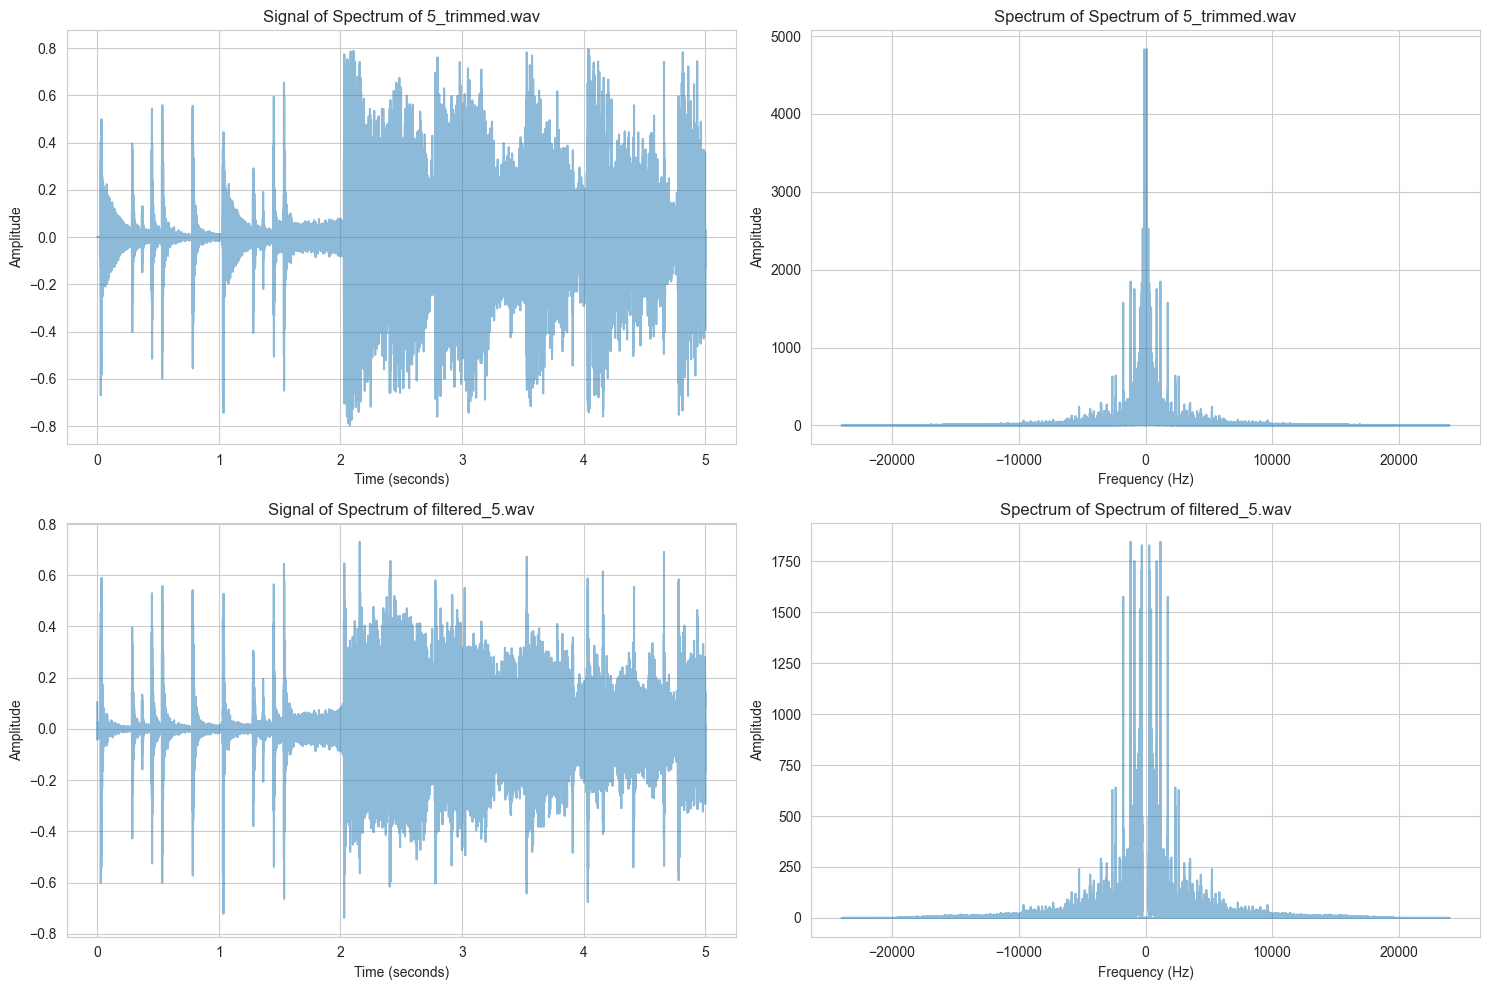

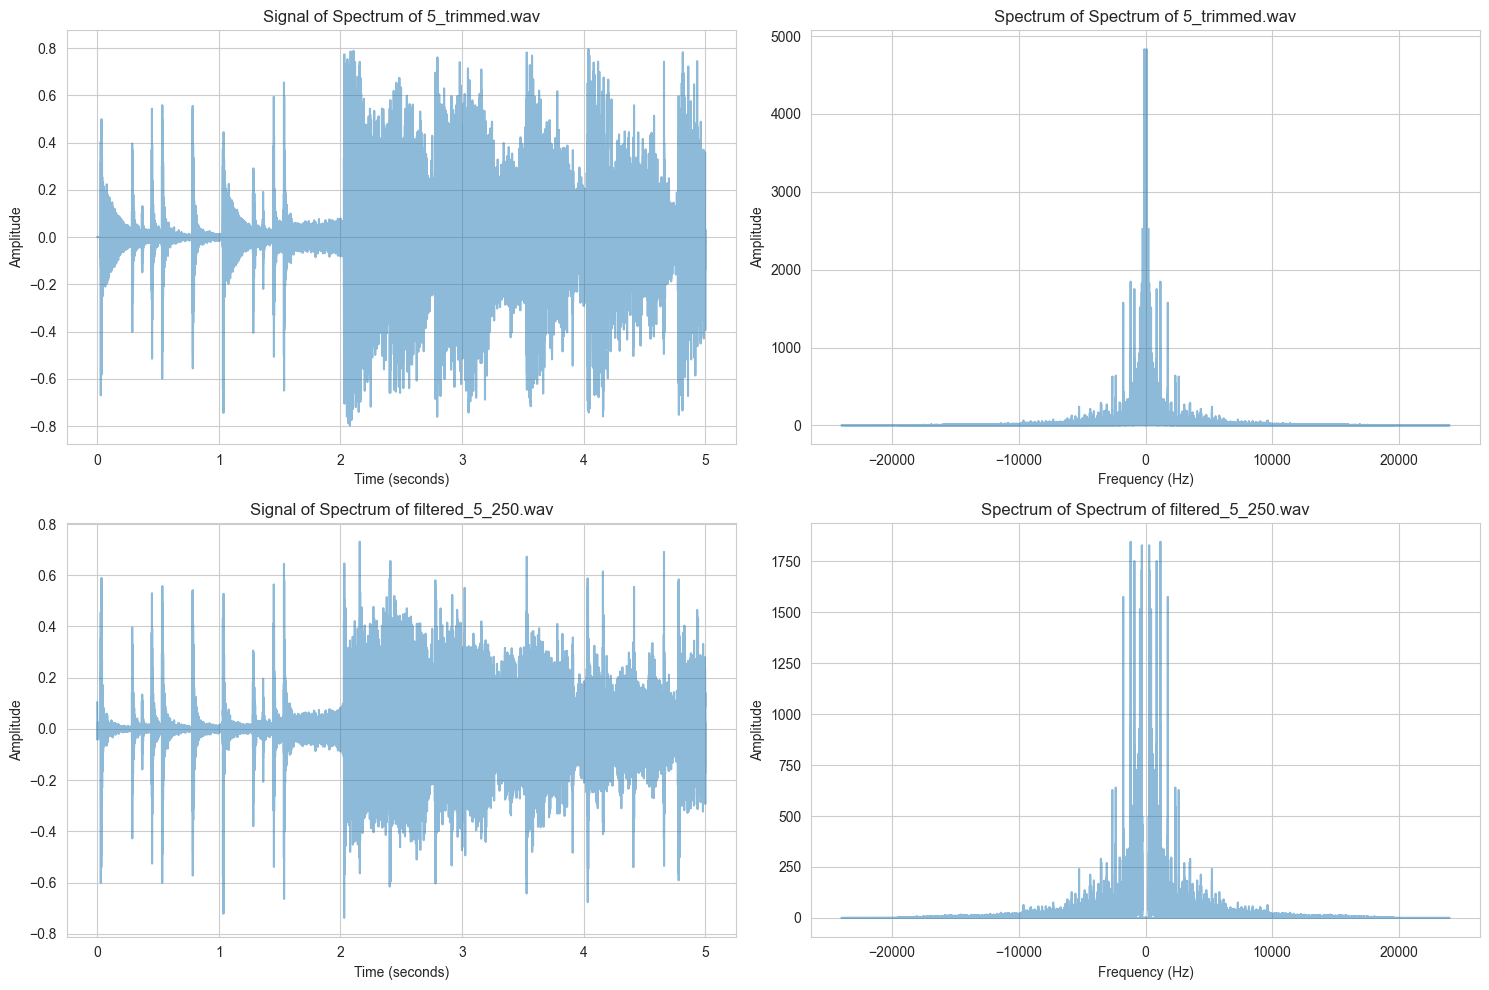

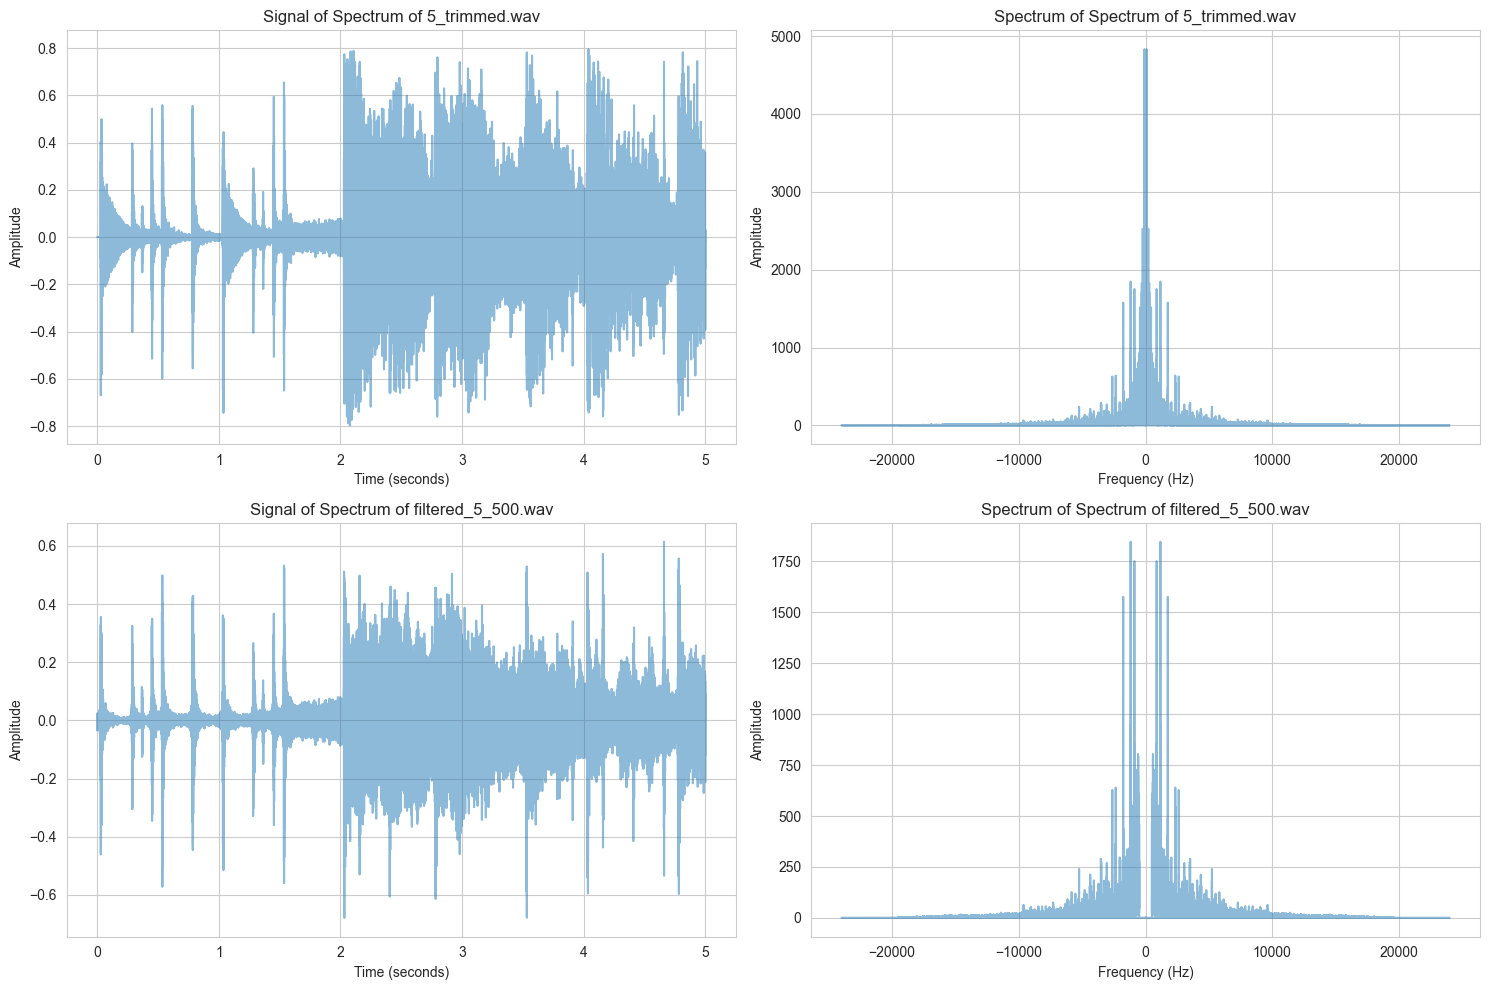

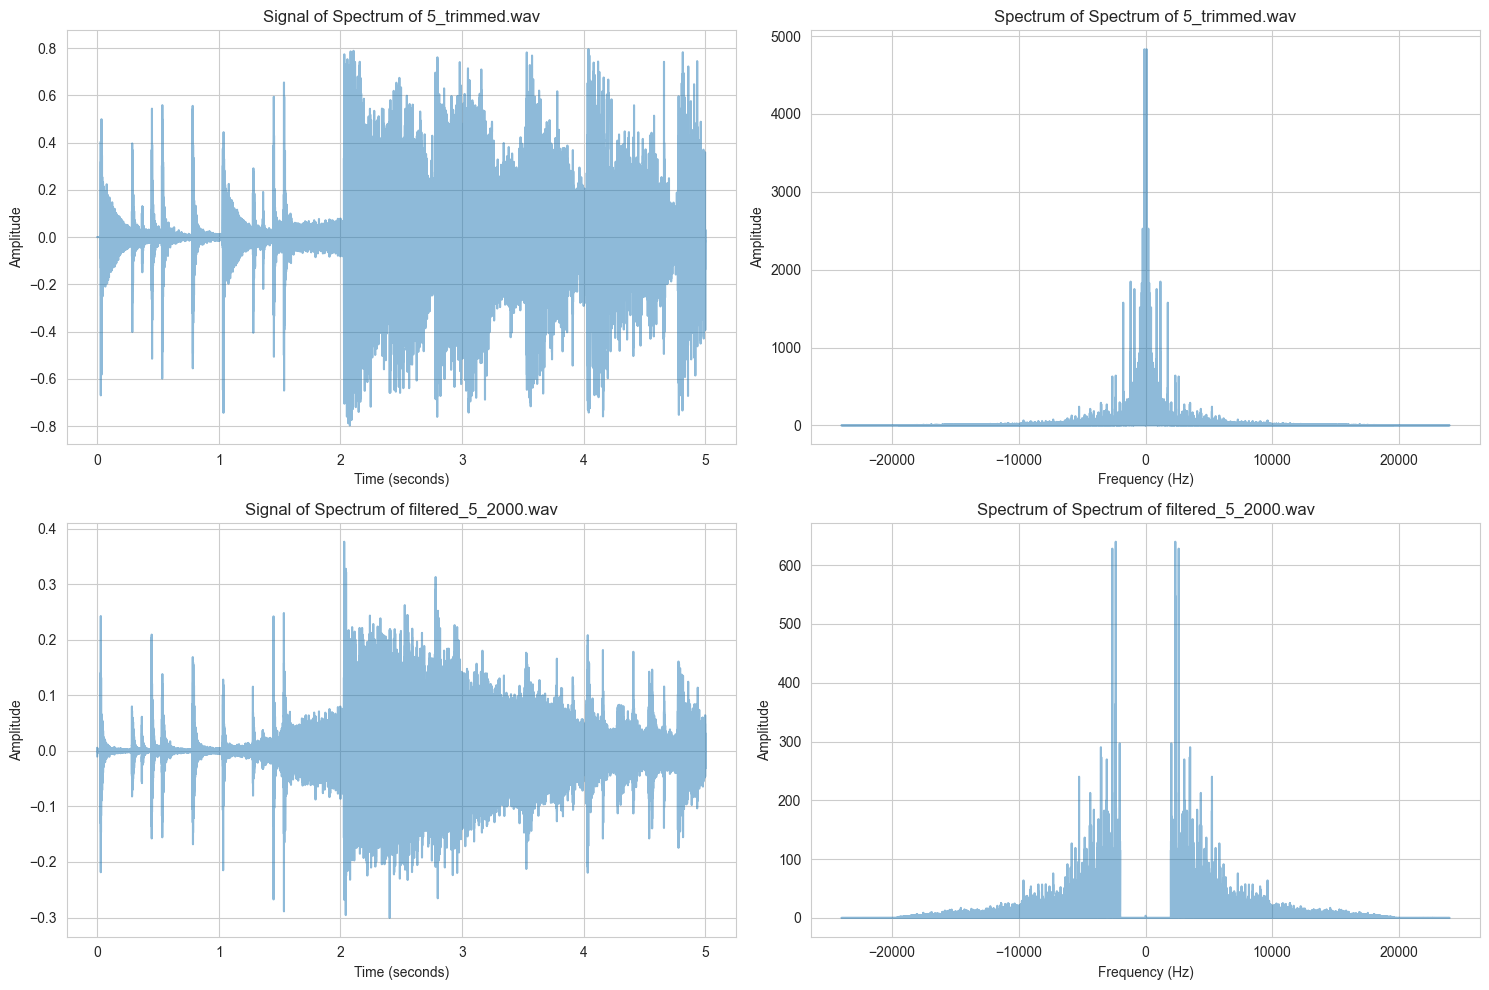

MSE von 5_trimmed.wav und filtered_5.wav ist: 0.02
MSE von 5_trimmed.wav und filtered_5_250.wav ist: 0.02
MSE von 5_trimmed.wav und filtered_5_500.wav ist: 0.02
MSE von 5_trimmed.wav und filtered_5_1000.wav ist: 0.03
MSE von 5_trimmed.wav und filtered_5_2000.wav ist: 0.03


In [106]:
for file in file_list:
    print(file)
    display(Audio(filename=f"data/signals/{file}"))

# Plot the spectrum
plot_compare_signals_and_spectrums(file_path1='data/signals/5_trimmed.wav',
               file_path2='data/signals/filtered_5_250.wav',
               title_1="Spectrum of 5_trimmed.wav",
               title_2="Spectrum of filtered_5.wav")

# Plot the spectrum
plot_compare_signals_and_spectrums(file_path1='data/signals/5_trimmed.wav',
               file_path2='data/signals/filtered_5_250.wav',
               title_1="Spectrum of 5_trimmed.wav",
               title_2="Spectrum of filtered_5_250.wav")

# Plot the spectrum
plot_compare_signals_and_spectrums(file_path1='data/signals/5_trimmed.wav',
               file_path2='data/signals/filtered_5_500.wav',
               title_1="Spectrum of 5_trimmed.wav",
               title_2="Spectrum of filtered_5_500.wav")

# Plot the spectrum
plot_compare_signals_and_spectrums(file_path1='data/signals/5_trimmed.wav',
               file_path2='data/signals/filtered_5_1000.wav',
               title_1="Spectrum of 5_trimmed.wav",
               title_2="Spectrum of filtered_5_1000.wav")

# Plot the spectrum
plot_compare_signals_and_spectrums(file_path1='data/signals/5_trimmed.wav',
               file_path2='data/signals/filtered_5_2000.wav',
               title_1="Spectrum of 5_trimmed.wav",
               title_2="Spectrum of filtered_5_2000.wav")

# calculate MSE for signal
mse_filtered_5 = calculate_1D_mse(file_path1="data/signals/5_trimmed.wav", 
                         file_path2="data/signals/filtered_5.wav", 
                         title_1="5_trimmed.wav", 
                         title_2="filtered_5.wav")

mse_filtered_5_250 = calculate_1D_mse(file_path1="data/signals/5_trimmed.wav",
                            file_path2="data/signals/filtered_5_250.wav",
                            title_1="5_trimmed.wav",
                            title_2="filtered_5_250.wav")

mse_filtered_5_500 = calculate_1D_mse(file_path1="data/signals/5_trimmed.wav",
                            file_path2="data/signals/filtered_5_500.wav",
                            title_1="5_trimmed.wav",
                            title_2="filtered_5_500.wav")

mse_filtered_5_1000 = calculate_1D_mse(file_path1="data/signals/5_trimmed.wav",
                            file_path2="data/signals/filtered_5_1000.wav",
                            title_1="5_trimmed.wav",
                            title_2="filtered_5_1000.wav")

mse_filtered_5_2000 = calculate_1D_mse(file_path1="data/signals/5_trimmed.wav",
                            file_path2="data/signals/filtered_5_2000.wav",
                            title_1="5_trimmed.wav",
                            title_2="filtered_5_2000.wav")



### 2.2.2 Bilder

In [102]:
# define function to visualize image transformations
def filter_image(original_image, remove_around_ft=None, get_statistical_info_ft=False):
    # Load image
    image = np.array(Image.open(original_image))
    
    # Convert to grayscale
    image_grey = np.array(Image.open(original_image).convert('L'))

    # Frequency domain
    ft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image_grey)))
    
    # Manipulate FT if required
    if remove_around_ft is not None:
        ft = ft.copy()
        ft[remove_around_ft] = 1
    
    # Inverse FT
    image_reconstructed = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(ft)).real)
    
    # Calculate MSE
    mse = np.square(np.subtract(image_grey, image_reconstructed)).mean()
    
    # Visualize images and FT
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image_grey, cmap='gray')
    axes[0].axis('off')
    axes[0].set_title("Grayscale Image", fontsize=10)
    
    axes[1].imshow(np.log(np.abs(ft) + 1), cmap='gray')
    axes[1].axis('off')
    axes[1].set_title("DFT", fontsize=10)
    
    axes[2].imshow(image_reconstructed, cmap='gray')
    axes[2].axis('off')
    axes[2].set_title(f"Reconstructed Image", fontsize=10)
    
    fig.suptitle(f"Visualizing Image Transformations \n Shape of Image {image_grey.shape} \nMSE: {mse:.2f}", fontsize=20, y=1.00)
    plt.tight_layout()
    plt.show()
    
    # Print statistical info
    if get_statistical_info_ft:
        print(f"Data Type: {ft.dtype}")
        print(f"Mean: {np.mean(ft):.2f}")
        print(f"Standard Deviation: {np.std(ft):.2f}")
        print(f"Minimum: {np.min(ft):.2f}")
        print(f"Maximum: {np.max(ft):.2f}")
        print(f"MSE: {mse:.2f}")

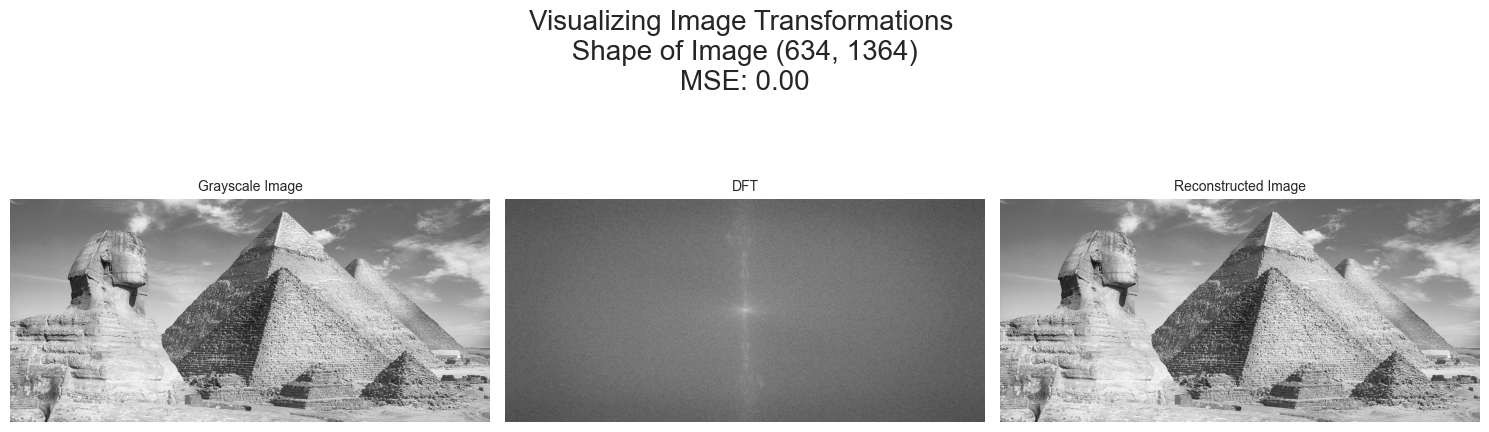

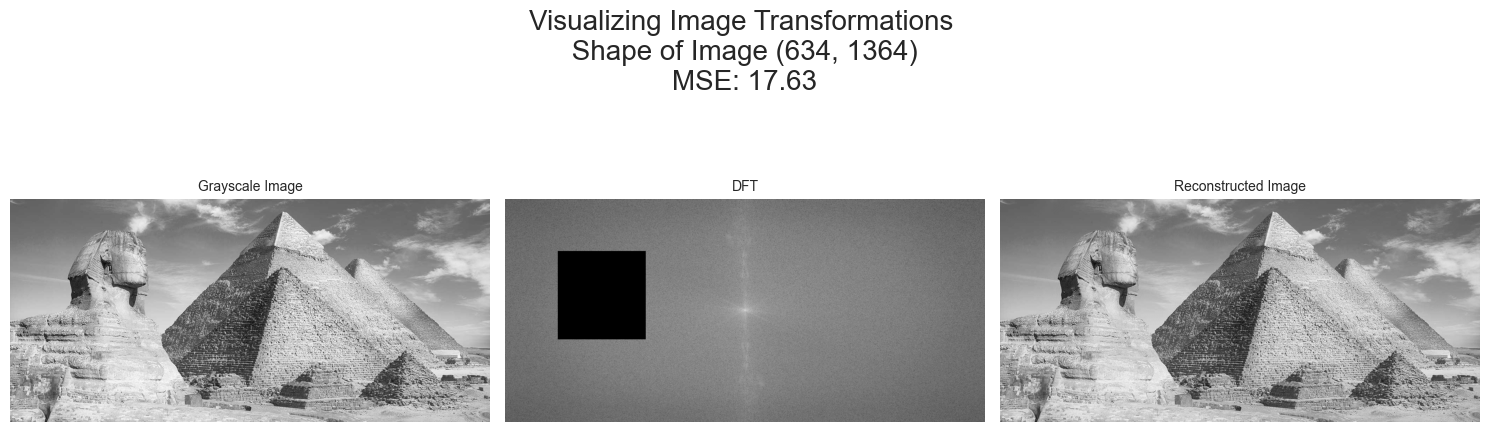

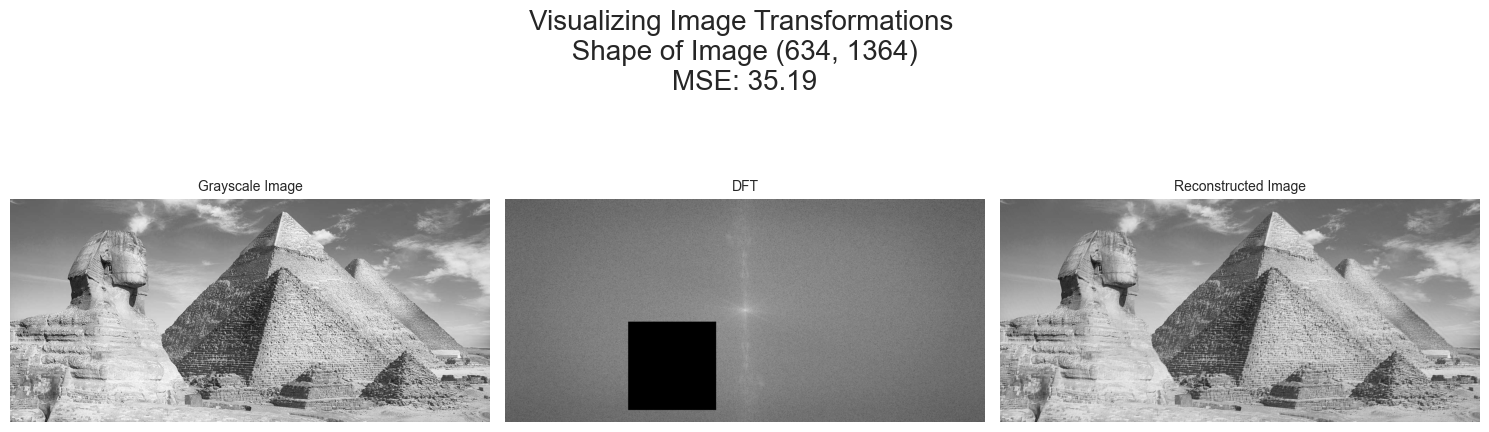

In [117]:
# create some sclicing objects into a list and iterate over them 
slices = [(slice(0, 0), slice(0, 0)), 
          (slice(150, 400), slice(150, 400)), 
          (slice(250, 500), slice(250, 500)), 
          (slice(350, 600), slice(350, 600)),
          (slice(450, 700), slice(450, 700)),]

for s in slices:
    filter_image(original_image="data/images/16.jpg", 
                                    remove_around_ft=s, 
                                    get_statistical_info_ft=False)

### 2.2.3 Diskussion

Datenwahl:    
Für die Signale wurden wieder der getrimmte 5.wav Audio Signal genommen. Beim Bild wurde das Bild 16.jpg genommen und anschliessend im grauen Farbkanal bearbeitet.

Methodenwahl:   
Analog wie beim Experiment 1.2.4 Bandbreite Filterung für das Signal. 
Um Bilder in die Spektrale Domäne zu transformieren nutzen wir die Fouriertransformation und schneiden dann bestimmte Bereich vom Bild ab und ersetzen diese durch 1. Dies führt dann bei der Rekonstruktion des Bildes zu einem Filtereffekt. 

Parameterwahl:
Es wurde eine For Schleife erstellt für die Filterung der Signale, um die Frequenzen zu filtern. Für die Bilder wurde ein Bereich definiert, welches wir filtern möchten.


Erzielte Ergebnisse:
Die steigende Filterung von den Frequenzen ist gut zu hören, dass dort die tiefen Signale stück für stück gefiltert werden. 

## 2.3. Bonus: Filterung in der räumlichen und spektralen Domäne
Führe optional Experimente mit Signalen oder Bildern mit Methoden durch, welche das Filtern in der räumlichen und der spektralen Domäne ermöglichen. Z.B. mittels Wavelets. Diskutiere deine Daten-, Parameter- und Methodenwahl und die erzielten Ergebnisse.

In [ ]:
# Trim Signal 5
trim_signal(file_path="data/signals/5.wav", filter_range=[0, 44100], output_file="data/signals/5_trimmed_1s.wav", export=True, seconds=False)

signal_experi1_files = ["5.wav", "5_trimmed_1s.wav"]

for file in signal_experi1_files:
    print(file)
    display(Audio(filename=f"data/signals/{file}"))

In [ ]:
def filter_dwt(file_path, filter_range=[0, None], output_file="filtered_audio.wav", export=False):
    """
    Load an audio file, compute its Discrete Wavelet Transform (DWT), filter it by frequency,
    and save the filtered audio.

    Parameters:
    file_path (str): path to the audio file.
    filter_range (list): list of two elements defining the start and end of the filter frequency range.
    output_file (str): path to save the filtered audio file.
    """
    # Load the audio file
    audio_data, sample_rate = librosa.load(file_path, sr=None)

    # Compute the Discrete Wavelet Transform (DWT) of the audio data
    coeffs = pywt.wavedec(audio_data, wavelet='db1')

    # Filter the DWT coefficients
    if filter_range[1] is None:
        filter_range[1] = sample_rate / 2
    
    num_coeffs_to_keep = int(np.log2(sample_rate / filter_range[1]))
    for i in range(num_coeffs_to_keep, len(coeffs)):
        coeffs[i][:] = 0
    
    # Inverse DWT to convert back to time domain
    filtered_audio = pywt.waverec(coeffs, wavelet='db1')

    # If export is True, save the filtered audio
    if export:
        sf.write(output_file, filtered_audio, sample_rate)

# Use function to filter audio signal in range [0, 1000] Hz
filter_dwt("data/signals/5_trimmed_1s.wav", 
           filter_range=[0, 20000], 
           output_file="data/signals/filtered_dwt_5.wav", 
           export=True)

# CHATGPT

In [ ]:
signal_experi1_files = ["5_trimmed_1s.wav", "filtered_dwt_5.wav"]

for file in signal_experi1_files:
    print(file)
    display(Audio(filename=f"data/signals/{file}"))

# plot the spectrum
plot_compare_signals_and_spectrums(file_path1='data/signals/5_trimmed_1s.wav',
               file_path2='data/signals/filtered_dwt_5.wav',
               title_1="Spectrum of 5_trimmed_1s.wav",
               title_2="Spectrum of filtered_dwt_5.wav")

### 2.3.1 Diskussion

Datenwahl:

Methodenwahl:

Parameterwahl:

Erzielte Ergebnisse:

## 2.4. Algorithmen zur Erkennung von Strukturen in Bildern
Zeige die einzelnen Schritte eines bekannten klassischen Bildverarbeitungs-Algorithmus zur Detektion von {'Kreisen'} in einem geeigneten Beispielbild deines Landes. Die einzelnen Schritte können selbst programmiert sein oder von Bibliotheken verwendet werden. Wichtig ist, dass Zwischenergebnisse der Schritte ersichtlich sind. Beschreibe zudem, was in jedem einzelnen Schritt konzeptionell relevant ist. Diskutiere deine Daten-, Methoden- und Parameterwahl sowie die erzielten Ergebnisse. Für welche Fälle funktioniert dein Algorithmus gut bzw. schlecht? Warum hast du dieses Bild gewählt?


Wir nehmen das Bil vom Experiment 1.1.5, da sich in diesen Bilder einige Kreise befinden.

https://www.geeksforgeeks.org/circle-detection-using-opencv-python/

In [ ]:
def detect_circle(file_path, param1, param2, minRadius, maxRadius):
    # Read image. 
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) 

    # Convert to grayscale. 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

    # Blur using 3 * 3 kernel. 
    gray_blurred = cv2.blur(gray, (3, 3)) 

    # Apply Hough transform on the blurred image. 
    detected_circles = cv2.HoughCircles(gray_blurred,  
                    cv2.HOUGH_GRADIENT, 1, 20, param1=param1, 
                    param2=param2, minRadius=minRadius, maxRadius=maxRadius) 

    # Draw circles that are detected. 
    if detected_circles is not None: 

        # Convert the circle parameters a, b and r to integers. 
        detected_circles = np.uint16(np.around(detected_circles)) 

        for pt in detected_circles[0, :]: 
            a, b, r = pt[0], pt[1], pt[2] 

            # Draw the circumference of the circle. 
            cv2.circle(img, (a, b), r, (0, 255, 0), 2) 

            # Draw a small circle (of radius 1) to show the center. 
            cv2.circle(img, (a, b), 1, (0, 0, 255), 3) 

    # Convert BGR image to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Detected Circles \nparam1: {param1}, param2: {param2} \nminRaius: {minRadius}, maxRadius: {maxRadius}", fontsize=10)
    plt.show()

detect_circle('data/images/26.jpg', param1=110, param2=53, minRadius=10, maxRadius=50)


In [ ]:
# Create a for loop for param 1 and 2
for param1 in np.linspace(105, 115, 3):
    for param2 in np.linspace(50, 60, 5):
        detect_circle('data/images/26.jpg', param1=param1, param2=param2, minRadius=10, maxRadius=50)

### 2.4.1 Diskussion

Datenwahl:

Methodenwahl:

Parameterwahl:

Erzielte Ergebnisse:


Für welche Fälle funktioniert dein Algorithmus gut bzw. schlecht? 
Warum hast du dieses Bild gewählt?   



# 3 Peer-Grading
Nach Abgabe der Mini-Challenge hast du 1 Woche Zeit eine dir zugeordnete Abgabe von anderen zu bewerten. Die Zuordnung erfolgt via FHNW Peer-Grading-Tool (siehe Link unten). Orientiere dich für die Bewertung an den vorgegebenen Bewertungskriterien (siehe Excel-Datei oder Peer-Grading-Tool). Die Note 5 bedeutet, dass alles erfüllt ist, wie du es von einem guten Data Scientist in der Praxis erwarten würdest. Du startest als Baseline mit der Note 5. Entdeckst du Fehler, geht die Note nach unten. Der Note 5.5 nähert man sich, wenn die Erwartungen übertroffen wurden. Der Note 6 nähert man sich, wenn die Leistung ausserordentlich oder mit einer unglaublichen Eigenleistung verbunden ist bzw. es gar nicht mehr besser geht. Kritisches Denken, Vielfalt von Experimenten und eigene Ideen werden positiv bewertet. Siehe auch Checkliste für Bewertung. Die Benotung soll auf Zehntel gerundet sein. Wer auf Zehntel gerundet mit 0.1 Abweichung die Endnote von der Fachexpertin trifft, kriegt einen Bonus von 0.2 Noten für die eigene Abgabe. In der Sprechstunde vom 7. November widmen wir uns dem Peer-Grading. 
FHNW Peer-Grading-Tool
